# Setup Model and FEM (according to E2)

# Bayesian Parameter Identification

In [1]:
!pip install tqdm
!pip install seaborn
!pip install pot

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.7/57.7 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.5/78.5 kB 9.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.9/294.9 kB 8.0 MB/s eta 0:00:00ta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 867.3/867.3 kB 19.8 MB/s eta 0:00:0000:01


In [2]:
# For better printing within jupyter cells (otherwise only the last variable is printed)
import IPython; IPython.core.interactiveshell.InteractiveShell.ast_node_interactivity = "all"

# Standard python libraries
import os

# General computing libraries
import math
import numpy
import scipy.optimize
import seaborn as sns
from scipy.stats import gaussian_kde
from ot.bregman import barycenter_sinkhorn
import ot

# Meshing libraries
import gmsh
import meshio

# Finite element libraries
import dolfin as df
df.parameters["allow_extrapolation"] = True
df.set_log_active(False)

# Plotting libraries
import matplotlib.pyplot as plt
from tqdm import tqdm

# VTK and visualization
import itkwidgets
import vtk

# Tracking libraries
import dolfin_warp as dwarp

# MEC581 python library
import LIB581

In [3]:
def create_mesh(
        X0,                   # first component of the center of the tube, in mm
        Y0,                   # second component of the center of the tube, in mm
        Ri,                   # internal radius of the tube, in mm
        Re,                   # external radius of the tube, in mm
        l,                    # characteristic size of the mesh cells, in mm
        mesh_folder="Project",     # folder the mesh file
        mesh_basename="mesh", # basename of the mesh file
        verbose=False):       # print or not the GMSH output

    ## Initialization of GMSH
    gmsh.initialize()
    if not (verbose): gmsh.option.setNumber("General.Terminal",0)
    gmsh.clear()

    ## Geometry
    factory = gmsh.model.geo

    # Points
    p0 = factory.addPoint(X0, Y0, 0, l) ### YOUR CODE HERE ###
    # 4 points on the inner loop
    p1 = factory.addPoint(X0+Ri, Y0, 0, l)
    p2 = factory.addPoint(X0, Y0+Ri, 0, l)
    p3 = factory.addPoint(X0-Ri, Y0, 0, l)
    p4 = factory.addPoint(X0, Y0-Ri, 0, l)
    # 4 points on the outer loop
    p5 = factory.addPoint(X0+Re, Y0, 0, l)
    p6 = factory.addPoint(X0, Y0+Re, 0, l)
    p7 = factory.addPoint(X0-Re, Y0, 0, l)
    p8 = factory.addPoint(X0, Y0-Re, 0, l)

    # Curves
    # 4 curves for the inner loop
    l11 = factory.addCircleArc(p1, p0, p2) ### YOUR CODE HERE ###
    l12 = factory.addCircleArc(p2, p0, p3)
    l13 = factory.addCircleArc(p3, p0, p4)
    l14 = factory.addCircleArc(p4, p0, p1)
    # 4 curves for the outer loop
    l21 = factory.addCircleArc(p5, p0, p6)
    l22 = factory.addCircleArc(p6, p0, p7)
    l23 = factory.addCircleArc(p7, p0, p8)
    l24 = factory.addCircleArc(p8, p0, p5)
    

    # Curve loop
    cl = factory.addCurveLoop([l11, l12, l13, l14, l21, l22, l23, l24])### YOUR CODE HERE ###

    # Surface
    s = factory.addPlaneSurface([cl]) ### YOUR CODE HERE ###

    # Synchronization, cf., e.g., https://gitlab.onelab.info/gmsh/gmsh/-/blob/master/tutorial/python/t1.py
    factory.synchronize()

    # In order to only save nodes and elements of the final surface
    # (i.e., not the construction points like the circle center,
    # nor the line elements of the line entities—remember that 
    # unstructured meshers will first mesh the curves, then the
    # surfaces and the volumes, cf. MEC552 L5.2), we declare it as a
    # "physical" surface.
    ps = gmsh.model.addPhysicalGroup(dim=2, tags=[s])

    ## Mesh
    mesh_gmsh = gmsh.model.mesh

    # Mesh generation
    mesh_gmsh.generate(dim=2)

    # In order to visualize the mesh and perform finite element computation using
    # FEniCS, we need to convert the mesh from the GMSH format to the VTK & FEniCS
    # formats. Since there is no direct converter between these formats, we do
    # that here by writing the mesh to the disc in VTK format using GMSH, which
    # we can then read in various formats later on.
    if not os.path.exists(mesh_folder): os.mkdir(mesh_folder)
    gmsh.write(mesh_folder+"/"+mesh_basename+".vtk")

    # Finalization of GMSH
    gmsh.finalize()

    # To convert the mesh from vtk to dolfin format,
    # we use [meshio](https://github.com/nschloe/meshio).
    mesh_meshio = meshio.read(mesh_folder+"/"+mesh_basename+".vtk")

    # For 2D meshes, we need to remove the third component of points,
    # otherwise FEniCS believes it is 3D…
    mesh_meshio.points = mesh_meshio.points[:, :2]

    # We write the mesh in XDMF format.
    meshio.write(mesh_folder+"/"+mesh_basename+".xdmf", mesh_meshio)

    # Finaly we can read the mesh in FEniCS format.
    mesh = df.Mesh()
    df.XDMFFile(mesh_folder+"/"+mesh_basename+".xdmf").read(mesh)

    return mesh

# Now we test the function.
mesh = create_mesh(X0=0.5, Y0=0.5, Ri=0.2, Re=0.3, l=0.1/5, verbose=1)

# We check some mesh informations.
print ("geometric_dimension:", mesh.geometric_dimension())
print ("num_vertices:", mesh.num_vertices())
print ("num_cells:", mesh.num_cells())

# We can define "measures", which allow to integrate expressions over (part of) the mesh.
dV = df.Measure("dx", domain=mesh) # "dx" means over the domain itself
mesh_V0 = df.assemble(df.Constant(1.) * dV)
print ("mesh_V0", mesh_V0)

# We visualize the mesh, by writing it to disk in VTK format, reading it,
# and using [itkwidgets](https://github.com/InsightSoftwareConsortium/itkwidgets).
LIB581.write_VTU_file("Project/mesh", mesh)
mesh_vtk = LIB581.read_VTU_file("Project/mesh")
itkwidgets.view(geometries=mesh_vtk)

Info    : Clearing all models and views...
Info    : Done clearing all models and views
Info    : Starting subloop 1 in curve loop 1 (are you sure about this?)
Info    : Meshing 1D...
Info    : [  0%] Meshing curve 1 (Circle)
Info    : [ 20%] Meshing curve 2 (Circle)
Info    : [ 30%] Meshing curve 3 (Circle)
Info    : [ 40%] Meshing curve 4 (Circle)
Info    : [ 50%] Meshing curve 5 (Circle)
Info    : [ 70%] Meshing curve 6 (Circle)
Info    : [ 80%] Meshing curve 7 (Circle)
Info    : [ 90%] Meshing curve 8 (Circle)
Info    : Done meshing 1D (Wall 0.00131018s, CPU 0.001699s)
Info    : Meshing 2D...
Info    : Meshing surface 1 (Plane, Frontal-Delaunay)
Info    : Done meshing 2D (Wall 0.0161707s, CPU 0.016207s)
Info    : 575 nodes 1157 elements
Info    : Writing 'Project/mesh.vtk'...
Info    : Done writing 'Project/mesh.vtk'
geometric_dimension: 2
num_vertices: 574
num_cells: 988
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this

Viewer(geometries=[{'vtkClass': 'vtkPolyData', 'points': {'vtkClass': 'vtkPoints', 'name': '_points', 'numberO…

In [4]:
def create_boundaries(
        X0, Y0, Ri, Re,
        mesh):

    # We create a "MeshFunction",
    # which will allow us to assign an id to each edge of the mesh.

    boundaries_mf = df.MeshFunction(
        value_type="size_t", # size_t is like unisgned int, but more robust with respect to architecture and os
        mesh=mesh,
        dim=1) # 0 for nodes, 1 for edges, 2 for faces, etc.

    # We initialize it to zero.

    boundaries_mf.set_all(0)

    # Now we define geometrical subdomains.

    Si_sd = df.AutoSubDomain(
        lambda x, on_boundary:
            on_boundary and\
            df.near((x[0]-X0)**2+(x[1]-Y0)**2, Ri**2, eps=1e-3))### YOUR CODE HERE ###

    Se_sd = df.AutoSubDomain(
        lambda x, on_boundary:
            on_boundary and\
            df.near((x[0]-X0)**2+(x[1]-Y0)**2, Re**2, eps=1e-3))### YOUR CODE HERE ###

    # And we use the subdomains to mark the different parts of the mesh.

    Si_id = 1; Si_sd.mark(boundaries_mf, Si_id)
    Se_id = 2; Se_sd.mark(boundaries_mf, Se_id)

    return boundaries_mf

# Now we test the function.
X0 = 0.5; Y0 = 0.5; Ri = 0.2; Re = 0.3; l=0.1/3
mesh = create_mesh(X0=X0, Y0=Y0, Ri=Ri, Re=Re, l=l)
boundaries_mf = create_boundaries(X0=X0, Y0=Y0, Ri=Ri, Re=Re, mesh=mesh)

# We can define "measures", which allow to integrate expressions over (part of) the mesh boundary.
dS = df.Measure("ds", domain=mesh, subdomain_data=boundaries_mf) # "ds" means over the domain boundary
mesh_S0 = df.assemble(df.Constant(1) * dS)
print ("mesh_S0", mesh_S0)
Si_id = 1; mesh_Si0 = df.assemble(df.Constant(1) * dS(Si_id))
print ("mesh_Si0", mesh_Si0)
Se_id = 2; mesh_Se0 = df.assemble(df.Constant(1) * dS(Se_id))
print ("mesh_Se0", mesh_Se0)

# We visualize the boundaries.
LIB581.write_VTU_file("Project/boundaries", boundaries_mf)
boundaries_vtk = LIB581.read_VTU_file("Project/boundaries")
itkwidgets.view(geometries=boundaries_vtk)

Calling FFC just-in-time (JIT) compiler, this may take some time.
mesh_S0 3.1394399563914983
Calling FFC just-in-time (JIT) compiler, this may take some time.
mesh_Si0 1.255345531645519
Calling FFC just-in-time (JIT) compiler, this may take some time.
mesh_Se0 1.8840944247459779


Viewer(geometries=[{'vtkClass': 'vtkPolyData', 'points': {'vtkClass': 'vtkPoints', 'name': '_points', 'numberO…

In [5]:
# We can define the finite element function space of the model,
# for instance here with second order Lagrange polynomials,

U_fs = df.VectorFunctionSpace(mesh, "Lagrange", degree=2)
#U_fs.dim()

# as well as the function into which we will store the solution.
# Dolfin functions are very convenient objects, which contain both
# a symbolic representation of the finite element approximation
# (i.e., the linear combination of the shape functions, which we 
# can derive, integrate, etc.) and the array containing the degrees
# of freedom (all the linear algebra is handled by [PETSc](https://www.mcs.anl.gov/petsc),
# which has a pretty ugly website but is one of the most efficient
# open source libraries for linear algebra, though we can also
# manipulate them as numpy arrays for convenience).

U = df.Function(U_fs, name="U")
#U
#df.grad(U)
#U.vector()
#U.vector().get_local()

# We can also define "test" and "trial" functions, which are abstract objects
# used to define linear and bilinear variational forms: a linear form 
# must be linear with respect to the "test" function (which is the U^*
# of the equations); a bilinear form must be linear in both the "test"
# function and "trial" function (which is the U of the equations in the 
# linear setting, the ΔU of the equations in the nonlinear setting, i.e.,
# it is the unknown of the linear problem).

U_test  = df.TestFunction(U_fs)
U_trial = df.TrialFunction(U_fs)

Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.


In [6]:
def create_bcs(
        X0, Y0, Ri, Re, U_fs):

    x1 = [X0+Ri, Y0]
    x1_sd = df.AutoSubDomain(
        lambda x, on_boundary: df.near(x[0], x1[0], eps=1e-3) and df.near(x[1], x1[1], eps=1e-3)) #define the subdomains as the 3 points
    x2 = [X0, Y0+Ri]
    x2_sd = df.AutoSubDomain(
        lambda x, on_boundary: df.near(x[0], x2[0], eps=1e-3) and df.near(x[1], x2[1], eps=1e-3))
    x3 = [X0-Ri, Y0]
    x3_sd = df.AutoSubDomain(
        lambda x, on_boundary: df.near(x[0], x3[0], eps=1e-3) and df.near(x[1], x3[1], eps=1e-3))

    bc1 = df.DirichletBC(U_fs.sub(1), 0, x1_sd, "pointwise") # Block first y translation DoF
    bc2 = df.DirichletBC(U_fs.sub(0), 0, x2_sd, "pointwise") # Block first x translation DoF
    bc3 = df.DirichletBC(U_fs.sub(1), 0, x3_sd, "pointwise") # Block translation DoF through second y translation block
    bcs = [bc1, bc2, bc3]

    return bcs

In [7]:
def create_mesh_boundaries_bcs_solution(
        X0, Y0, Ri, Re, l, degree):

    mesh = create_mesh(X0=X0, Y0=Y0, Ri=Ri, Re=Re, l=l)
    boundaries_mf = create_boundaries(X0=X0, Y0=Y0, Ri=Ri, Re=Re, mesh=mesh)
    U_fs = df.VectorFunctionSpace(mesh, "Lagrange", degree=degree)
    bcs = create_bcs(X0=X0, Y0=Y0, Ri=Ri, Re=Re, U_fs=U_fs)
    U = df.Function(U_fs, name="U")

    return mesh, boundaries_mf, bcs, U

In [8]:
def solve_linear_model(mesh, boundaries_mf, bcs, U, Y, nu, P, init_U=None):

    # Virtual work of internal forces
    # (We redefine the parameters as dolfin.Constant,
    #  such that dolfin does not recompile the variational forms
    #  for each value of the parameters.)

    Y     = df.Constant(Y)       # Young modulus (E already used for Green-Lagrange strain)
    nu    = df.Constant(nu)      # Poisson ratio
    lmbda = Y*nu/((1+nu)*(1-2*nu)) # Lamé constant (plane strain) ### YOUR CODE HERE ###
    mu    = Y/(2*(1+nu)) # Lamé constant ### YOUR CODE HERE ###

    U_trial = df.TrialFunction(U.function_space())
    epsilon_trial = df.sym(df.grad(U_trial)) ### YOUR CODE HERE ###
    sigma_trial = lmbda*df.tr(epsilon_trial)*df.Identity(2) + 2*mu*epsilon_trial ### YOUR CODE HERE ###

    U_test = df.TestFunction(U.function_space())
    epsilon_test = df.sym(df.grad(U_test)) ### YOUR CODE HERE ###

    dV = df.Measure("dx", domain=mesh)

    Wint = df.inner(sigma_trial, epsilon_test)*dV ### YOUR CODE HERE ###

    # Virtual work of external forces
    # (We redefine the parameters as dolfin.Constant,
    #  such that dolfin does not recompile the variational forms
    #  for each value of the parameters.)

    P = df.Constant(P)
    N = df.FacetNormal(mesh)
    dS = df.Measure("ds", domain=mesh, subdomain_data=boundaries_mf)
    Si_id = 1

    Wext = -P*df.inner(N, U_test)*dS(Si_id) ### YOUR CODE HERE ###

    # Linear solver

    df.solve(Wint==Wext, U, bcs) ### YOUR CODE HERE ###

In [9]:
def solve_nonlinear_model(mesh, boundaries_mf, bcs, U, Y, nu, P, init_U=None):

    # Kinematics
    # (We define C as a dolfin.variable,
    #  and derive all quantities (including J!) from it,
    #  such that we can later derive the energy with respect to C.)

    I    = df.Identity(2) ### YOUR CODE HERE ### # Identity
    F    = I + df.grad(U) ### YOUR CODE HERE ### # Deformation gradient
    C    = F.T*F ### YOUR CODE HERE ### # Right Cauchy-Green dilatation tensor
    C    = df.variable(C)
    IC   = df.tr(C) ### YOUR CODE HERE ### # First invariant
    IIIC = df.det(C) ### YOUR CODE HERE ### # Third invariant
    J    = df.sqrt(IIIC) ### YOUR CODE HERE ### # Volume ratio
    E    = 0.5*(C - I) ### YOUR CODE HERE ### # Green-Lagrange strain

    # Virtual work of internal forces
    # (We redefine the parameters as dolfin.Constant,
    #  such that dolfin does not recompile the variational forms
    #  for each value of the parameters.)

    Y     = df.Constant(Y)       # Young modulus (E already used for Green-Lagrange strain)
    nu    = df.Constant(nu)      # Poisson ratio
    lmbda = (Y*nu) / ((1.0 + nu)*(1.0 - 2.0*nu)) ### YOUR CODE HERE ### # Lamé constant (plane strain)
    mu    = Y/(2.0*(1.0 + nu)) ### YOUR CODE HERE ### # Lamé constant

    W  = 0.25*lmbda*(J**2 - 1.0 - 2.0*df.ln(J)) ### YOUR CODE HERE ### # Ogden-Ciarlet-Geymonat bulk energy
    W += 0.5*mu*(IC - 3.0 - 2.0*df.ln(J)) ### YOUR CODE HERE ### # Neo-Hookean energy (plane strain)
    Sigma = df.diff(W, C) ### YOUR CODE HERE ###

    U_test = df.TestFunction(U.function_space())
    delta_E = 0.5*(df.grad(U_test).T*F + F.T*df.grad(U_test)) ### YOUR CODE HERE ###

    dV = df.Measure("dx", domain=mesh)

    Wint = df.inner(Sigma, delta_E)*dV ### YOUR CODE HERE ###

    # Virtual work of external forces
    # (We redefine the parameters as dolfin.Constant,
    #  such that dolfin does not recompile the variational forms
    #  for each value of the parameters.)

    P = df.Constant(P)
    N = df.FacetNormal(mesh)
    dS = df.Measure("ds", domain=mesh, subdomain_data=boundaries_mf)
    Si_id = 1

    Wext = -df.dot(P*N, U_test)*dS(Si_id) ### YOUR CODE HERE ###

    # Nonlinear solver
    # (Note that for nonlinear problems solved using the Newton method,
    #  as is the case here, the initial solution of the iterations has a
    #  strong impact on convergence. Thus, we put an additional optional
    #  parameter to the function: if `init_U=True` (the default), the
    #  solution is initialized at 0 before starting the iterations;
    #  conversely, if `init_U=False`, the solution is not initialized,
    #  so the iterations start from the current displacement fields.

    res = Wint - Wext ### YOUR CODE HERE ###

    U_trial = df.TrialFunction(U.function_space())
    jac = df.derivative(res, U, U_trial) ### YOUR CODE HERE ###
    
    if (init_U): U.vector().zero()

    df.solve(res == 0, U, bcs, J=jac) ### YOUR CODE HERE ###

In [10]:
mesh, boundaries_mf, bcs, U = create_mesh_boundaries_bcs_solution(X0=0.5, Y0=0.5, Ri=0.2, Re=0.3, l=0.1/5, degree=2)
solve_nonlinear_model(mesh=mesh, boundaries_mf=boundaries_mf, bcs=bcs, U=U, Y=10., nu=0.3, P=+1.)

# To visualize the solution, we save it into the VTK format.
# (The displacement field is applied onto the mesh, which then represents the deformed configuration;
#  you can change the multiplicative factor of the displacement field to better see the deformation.)
LIB581.write_VTU_file("Project/model", U)
LIB581.Viewer(meshes="Project/model.vtu").view()

Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
           Consider using the option 'quadrature_degree' to reduce the number of points


# Bayesian Identification


### Define a distance measure

In [89]:
dV = df.Measure("dx", domain=mesh)
def compute_distance(U1, U2, eps=1e-10):
    """
    Computes a dimensionless distance between two displacement fields U1 and U2
    by dividing the L2 error by the L2 norm of U2.
    """
    # L^2 norm of the difference
    diff_L2 = df.sqrt(df.assemble(df.inner(U1 - U2, U1 - U2) * dV))
    
    # L^2 norm of the reference field U2
    ref_L2 = df.sqrt(df.assemble(df.inner(U2, U2) * dV))
    
    # Relative error (avoid division by zero in trivial cases)
    distance = diff_L2 / (ref_L2 + eps)
    return distance

## Single Experiment
### Set-Up

In [18]:
# Setup the simulation (geometry, mesh, boundaries, BCs, function space)
X0, Y0, Ri, Re, l = 0.5, 0.5, 0.2, 0.3, 0.1/5
mesh, boundaries_mf, bcs, U = create_mesh_boundaries_bcs_solution(
    X0=X0, Y0=Y0, Ri=Ri, Re=Re, l=l, degree=2)

# Define “true” parameters
true_Y = 10.0
nu = 0.3
P_obs = 1.0

# Prior for the Young modulus: Uniform over [Y_min, Y_max]
Y_min, Y_max = 5.0, 15.0

# Solve the forward (nonlinear) model with the true Young modulus
# solve_nonlinear_model(mesh=mesh, boundaries_mf=boundaries_mf, bcs=bcs, U=U, Y=true_Y, nu=nu, P=P_obs)
solve_linear_model(mesh=mesh, boundaries_mf=boundaries_mf, bcs=bcs, U=U, Y=true_Y, nu=nu, P=P_obs)


# Save the result as the observed displacement (deep copy the field)
U_obs = df.Function(U.function_space())
U_obs.assign(U)

Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.


### Setup ABC Rejection Algorithm

In [20]:
def ABC_rejection(U_obs, Y_min, Y_max, N_trials, epsilon, noise_mean, noise_sd):
    accepted_Y = []
    accepted_distances = []

    for i in range(N_trials):
        # Sample Y from the uniform prior
        Y_sample = np.random.uniform(Y_min, Y_max)

        # Solve the forward model with the sampled Young modulus
        # Note: use init_U=True to reinitialize the displacement field at each iteration.
        #solve_nonlinear_model(mesh=mesh, boundaries_mf=boundaries_mf, bcs=bcs, U=U, Y=Y_sample, nu=nu, P=P_obs, init_U=True)
        solve_linear_model(mesh=mesh, boundaries_mf=boundaries_mf, bcs=bcs, U=U, Y=Y_sample, nu=nu, P=P_obs, init_U=True)
        
        # Generate the noise 
        U.vector()[:] += numpy.random.normal(loc=noise_mean, scale=noise_sd, size=U.vector().get_local().shape)

        # Compute the discrepancy between the current simulation and the observed data
        d = compute_distance(U, U_obs)

        # Accept the sample if the error is below the threshold epsilon
        if d < epsilon:
            accepted_Y.append(Y_sample)
            accepted_distances.append(d)
            #print(f"Accepted {i}: Y_sample = {Y_sample:.3f}, distance = {d:.3f}")
        #else:
            #print(f"Rejected {i}: Y_sample = {Y_sample:.3f}, distance = {d:.3f}")

    #print("Number of accepted samples:", len(accepted_Y))
    
    return accepted_Y, accepted_distances

### Analyse the approximate Posterior

Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Number of accepted samples: 155/200


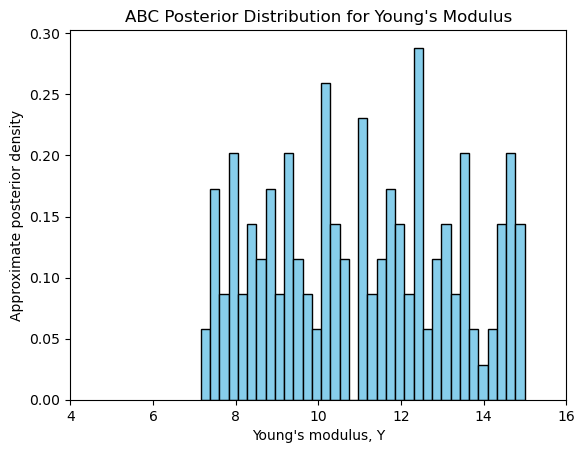

In [16]:
# Noise parameters
noise_mean = 0
noise_sd = 0.01

# Prior for the Young modulus: Uniform over [Y_min, Y_max]
Y_min, Y_max = 5.0, 15.0

# Number of trials and acceptance threshold (tune epsilon as needed)
N_trials = 200
epsilon = 0.5  # adjust this threshold to control the acceptance rate

accepted_Y, accepted_distances = ABC_rejection(U_obs, Y_min, Y_max, N_trials, epsilon, noise_mean, noise_sd)

print(f"Number of accepted samples: {len(accepted_Y)}/{N_trials}", )

# Plot the histogram of accepted Young modulus values
plt.hist(accepted_Y, bins=35, density=True, color="skyblue", edgecolor="black")
plt.xlabel("Young's modulus, Y")
plt.ylabel("Approximate posterior density")
plt.title("ABC Posterior Distribution for Young's Modulus")
plt.xlim(Y_min-1, Y_max+1)  # Force x-axis to always span from Y_min to Y_max
plt.show();

### ABC method but weighing with the inverse of the cost function

In [21]:
def ABC_weighted(U_obs, Y_min, Y_max, N_trials, noise_mean, noise_sd):
    # Small constant to avoid division by zero in weights
    eps_w = 1e-3
    
    # Lists to store samples and their weights
    all_samples = []
    all_weights = []

    for i in range(N_trials):
        # Sample Y from the uniform prior
        Y_sample = np.random.uniform(Y_min, Y_max)

        # Solve the forward model with the sampled Young modulus.
        # Use init_U=True to reinitialize the displacement field.
        #solve_nonlinear_model(mesh=mesh, boundaries_mf=boundaries_mf, bcs=bcs, U=U, Y=Y_sample, nu=nu, P=P_obs, init_U=True)
        solve_linear_model(mesh=mesh, boundaries_mf=boundaries_mf, bcs=bcs, U=U, Y=Y_sample, nu=nu, P=P_obs, init_U=True)
        U.vector()[:] += numpy.random.normal(loc=noise_mean, scale=noise_sd, size=U.vector().get_local().shape)


        # Compute the discrepancy between current simulation and observed data
        d = compute_distance(U, U_obs)

        # Compute weight (larger weight for smaller discrepancy)
        weight = 1.0 / (d + eps_w)

        # Store the sample and its weight
        all_samples.append(Y_sample)
        all_weights.append(weight)

        #print(f"Sample {i+1}/{N_trials}: Y = {Y_sample:.3f}, distance = {d:.3f}, weight = {weight:.3f}")

    # Convert lists to numpy arrays for easier manipulation
    all_samples = np.array(all_samples)
    all_weights = np.array(all_weights)

    # Normalize weights to sum to 1 (if desired)
    all_weights_norm = all_weights / np.sum(all_weights)
    
    return all_samples, all_weights_norm

### ABC method with the weighing & $\epsilon$ rejection

In [22]:
def ABC_weighted_rejection(U_obs, Y_min, Y_max, N_trials, noise_mean, noise_sd, epsilon):
    # Small constant to avoid division by zero in weights
    eps_w = 0.001
    
    # Lists to store samples and their weights
    all_samples = []
    all_weights = []

    for i in range(N_trials):
        # Sample Y from the uniform prior
        Y_sample = np.random.uniform(Y_min, Y_max)

        # Solve the forward model with the sampled Young modulus.
        # Use init_U=True to reinitialize the displacement field.
        #solve_nonlinear_model(mesh=mesh, boundaries_mf=boundaries_mf, bcs=bcs, U=U, Y=Y_sample, nu=nu, P=P_obs, init_U=True)
        solve_linear_model(mesh=mesh, boundaries_mf=boundaries_mf, bcs=bcs, U=U, Y=Y_sample, nu=nu, P=P_obs, init_U=True)
        
        U.vector()[:] += numpy.random.normal(loc=noise_mean, scale=noise_sd, size=U.vector().get_local().shape)


        # Compute the discrepancy between current simulation and observed data
        d = compute_distance(U, U_obs)
        
         # Compute weight (larger weight for smaller discrepancy)
        if d > epsilon :
            weight = eps_w/100
        else :
            weight = 1.0 / (d + eps_w)


        # Store the sample and its weight
        all_samples.append(Y_sample)
        all_weights.append(weight)

        #print(f"Sample {i+1}/{N_trials}: Y = {Y_sample:.3f}, distance = {d:.3f}, weight = {weight:.3f}")

    # Convert lists to numpy arrays for easier manipulation
    all_samples = np.array(all_samples)
    all_weights = np.array(all_weights)

    # Normalize weights to sum to 1 (if desired)
    weight_sum = np.sum(all_weights)
    if weight_sum > 0:
        all_weights_norm = all_weights / weight_sum
    else:
        # Handle the case where all weights are zero or very small
        print("Warning: Sum of weights is zero, skipping normalization.")
        all_weights_norm = all_weights  # or handle it as you prefer
    
    return all_samples, all_weights_norm

### Using half rejection to refine the bounds (c.f. last year) & weighing

In [23]:
def ABC_half_rejection_method(U_obs, Y_tilde, eps, N_steps, N_trials, noise_mean, noise_sd):
    # Initial bounds for Young's modulus
    Y_min_ini, Y_max_ini = Y_tilde - eps, Y_tilde + eps 

    eps_w = 1e-6   # Small number to avoid division by zero in weight calculation

    all_Y_samples = []
    all_weights = []

    for n in range(N_steps):
        Y_d_list = []

        #print(f"Sampling from Uniform[{Y_min_ini:.3f}, {Y_max_ini:.3f}]")
        # Sampling and evaluating discrepancy
        for i in range(N_trials):
            # Sample Y from the uniform prior
            Y_sample = np.random.uniform(Y_min_ini, Y_max_ini)

            # Solve the forward model
            solve_linear_model(mesh=mesh, boundaries_mf=boundaries_mf, bcs=bcs, U=U, Y=Y_sample, nu=nu, P=P_obs, init_U=True)
            U.vector()[:] += numpy.random.normal(loc=noise_mean, scale=noise_sd, size=U.vector().get_local().shape)

            
            # Compute the discrepancy between current simulation and observed data
            d_sample = compute_distance(U, U_obs)

            # Compute weight (higher weight for lower discrepancy)
            weight = 1.0 / (d_sample + eps_w)

            # Store the sample and its weight
            all_Y_samples.append(Y_sample)
            all_weights.append(weight)

            # Store for updating bounds
            Y_d_list.append((Y_sample, d_sample))

            #print(f"Sample {i+1}/{N_trials}: Y = {Y_sample:.3f}, distance = {d_sample:.6f}, weight = {weight:.6f}")

        # Sort samples by discrepancy (ascending)
        Y_d_list.sort(key=lambda x: x[1])

        # Select the best 50% samples (half with the lowest d values)
        top_half = Y_d_list[:N_trials // 2]

        # Update Y_min_ini and Y_max_ini to the range of the selected top samples
        Y_min_ini = min(y for y, _ in top_half)
        Y_max_ini = max(y for y, _ in top_half)

        #print(f"Updated bounds after Step {n+1}: Y_min = {Y_min_ini:.3f}, Y_max = {Y_max_ini:.3f}")
        
    # Convert lists to numpy arrays
    all_Y_samples = np.array(all_Y_samples)
    all_weights = np.array(all_weights)

    # Normalize weights safely
    weight_sum = np.sum(all_weights)
    if weight_sum > 0:
        all_weights_norm = all_weights / weight_sum
    else:
        all_weights_norm = all_weights

    return all_Y_samples, all_weights_norm

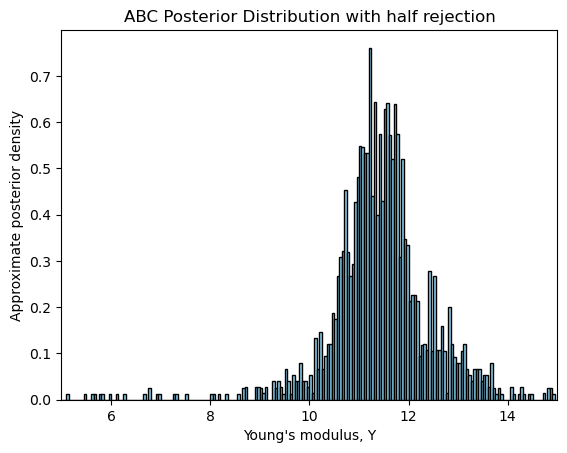

In [46]:
Y_tilde = 10
eps = 5
N_steps = 30
N_trials = 50

all_Y_samples, all_weights_norm = ABC_half_rejection_method(U_obs, Y_tilde, eps, N_steps, N_trials, noise_mean, noise_sd)
        
# Plot a weighted histogram of the samples
plt.hist(all_Y_samples, bins=200, density=True, weights=all_weights_norm,
         range=(Y_tilde - eps, Y_tilde + eps), color="skyblue", edgecolor="black")

plt.xlabel("Young's modulus, Y")
plt.ylabel("Approximate posterior density")
plt.title("ABC Posterior Distribution with half rejection")
plt.xlim(Y_tilde - eps, Y_tilde + eps)  # Force x-axis to always span from Y_min_ini to Y_max_ini
plt.show();

## Multiple Experiments - true_Y stays the same

Here, we simulate the setting that you have a specimen but do multiple different experiments on it. You want to find the single parameter for this specimen without the measurement noise.

Should converge to a dirac that represents the parameter for this singe specimen that you ran multiple experiments on

In [21]:
# Prior for the Young modulus: Uniform over [Y_min, Y_max]
Y_min, Y_max = 5.0, 15.0

# Use the same Y but with noise for the different experiments
Y_true = 10
noise_mean = 0
noise_sd = 0.01

### Distribution with different bayesian methods

#### $\epsilon$ rejection

In [22]:
# Number of experiments to run
n_experiments = 2
N_trials = 100
epsilon = 0.5  # acceptance threshold

# Storage for results from all experiments
all_experiment_accepted_Y = []

# Run multiple experiments
for exp in tqdm(range(n_experiments), ncols= 100):
    # Generate the noise
    noise = np.random.normal(loc=noise_mean, scale=noise_sd, size=U_obs.vector().get_local().shape)
    
    # Generate synthetic observation with this Y_true
    solve_linear_model(mesh=mesh, boundaries_mf=boundaries_mf, bcs=bcs, U=U, 
                      Y=Y_true, nu=nu, P=P_obs)
    U_obs = df.Function(U.function_space())
    U_obs.assign(U)
    
    # Add noise to the model the real measurement
    U_obs.vector()[:] += noise
    
    # Run ABC for this observation
    accepted_Y, _ = ABC_rejection(U_obs, Y_min, Y_max, N_trials, epsilon, noise_mean, noise_sd)

    #print(f"Experiment {exp+1} finished with {len(accepted_Y)} accepted samples")
    all_experiment_accepted_Y.append(np.array(accepted_Y))


100%|█████████████████████████████████████████████████████████████████| 2/2 [00:28<00:00, 14.11s/it]


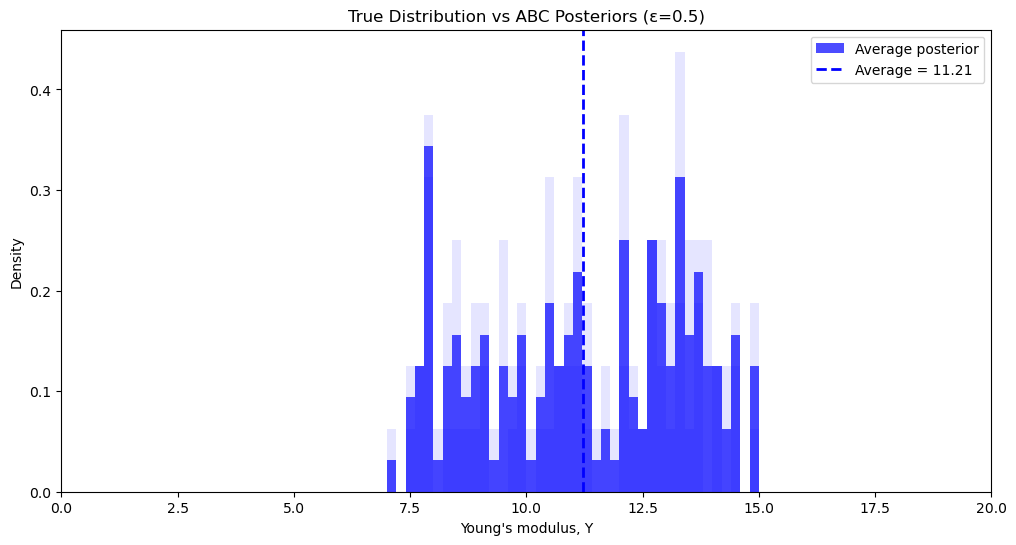


Summary Statistics:
Total number of experiments: 2
Average number of accepted samples per experiment: 80.0/100
Total number of accepted samples: 160


In [23]:
# Plot results
bins = 50
fig = plt.figure(figsize=(12, 6));
# Plot the true Y distribution
#y_range = np.linspace(Y_min, Y_max, 100)
#plot = plt.plot(y_range, true_Y_dist.pdf(y_range), 'r-', label='True Y distribution', linewidth=2);

# Plot individual experiment posteriors (semi-transparent)
for accepted_Y in all_experiment_accepted_Y:
    if len(accepted_Y) > 0:  # Only plot if there are accepted samples
        hist = plt.hist(accepted_Y, bins=bins, density=True,
                alpha=0.1, color='blue', range=(Y_min, Y_max));

# Plot average posterior
combined_accepted_Y = np.concatenate([Y for Y in all_experiment_accepted_Y if len(Y) > 0])
if len(combined_accepted_Y) > 0:
    hist = plt.hist(combined_accepted_Y, bins=bins, density=True,
             alpha=0.7, color='blue', range=(Y_min, Y_max),
             label='Average posterior');
    
    # Calculate the average (mean) of the posterior
    average_posterior = np.mean(combined_accepted_Y)

    # Plot the average posterior as a vertical line
    line = plt.axvline(average_posterior, color='blue', linestyle='dashed', linewidth=2, label=f'Average = {average_posterior:.2f}')


xlabel = plt.xlabel("Young's modulus, Y");
ylabel = plt.ylabel("Density");
tite = plt.title(f"True Distribution vs ABC Posteriors (ε={epsilon})");
legend = plt.legend();
slim = plt.xlim(Y_min-5, Y_max+5);
plt.show();

# Print some statistics
print("\nSummary Statistics:")
print(f"Total number of experiments: {n_experiments}")
print(f"Average number of accepted samples per experiment: {np.mean([len(Y) for Y in all_experiment_accepted_Y]):.1f}/{N_trials}")
print(f"Total number of accepted samples: {len(combined_accepted_Y)}")

#### Weighing

In [24]:
# Number of experiments & trials to run
n_experiments = 2
N_trials = 100

# Storage for results from all experiments
all_experiment_samples = []
all_experiment_weights = []

# Run multiple experiments
for exp in tqdm(range(n_experiments), ncols= 100):
    # Generate the noise
    noise = np.random.normal(loc=noise_mean, scale=noise_sd, size=U_obs.vector().get_local().shape)
    
    # Generate synthetic observation with this Y_true
    solve_linear_model(mesh=mesh, boundaries_mf=boundaries_mf, bcs=bcs, U=U, 
                      Y=Y_true, nu=nu, P=P_obs)
    U_obs = df.Function(U.function_space())
    U_obs.assign(U)
    
    # Add noise
    U_obs.vector()[:] += noise

    all_samples, all_weights_norm = ABC_weighted(U_obs, Y_min, Y_max, N_trials, noise_mean, noise_sd)
    
    # Store results
    all_experiment_samples.append(np.array(all_samples))
    all_experiment_weights.append(all_weights_norm)


100%|█████████████████████████████████████████████████████████████████| 2/2 [00:28<00:00, 14.12s/it]


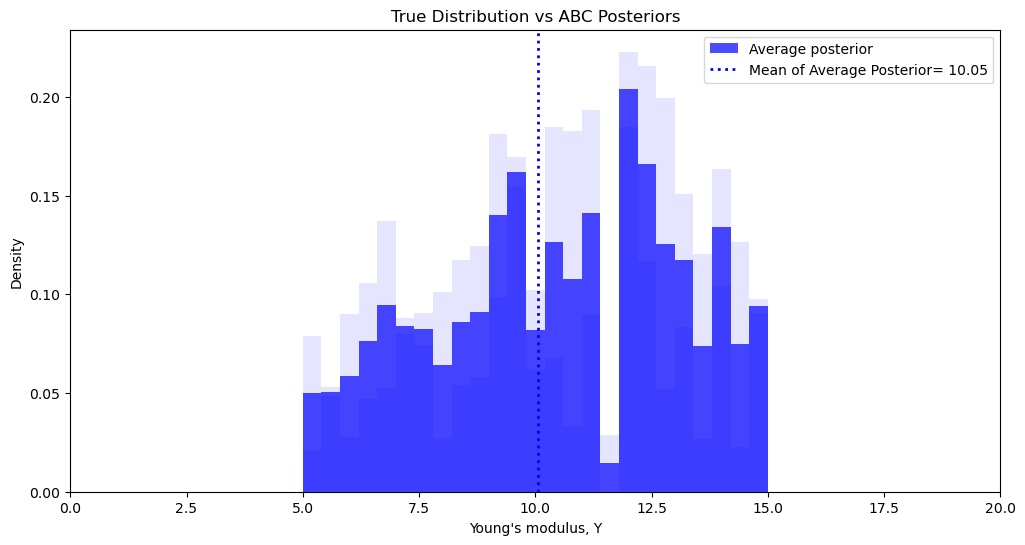

In [25]:
# Plot results
plt.figure(figsize=(12, 6))
bins = 25

# Plot individual experiment posteriors (semi-transparent)
for samples, weights in zip(all_experiment_samples, all_experiment_weights):
    plt.hist(samples, bins=bins, density=True, weights=weights,
             alpha=0.1, color='blue', range=(Y_min, Y_max))

# Plot average posterior
combined_samples = np.concatenate(all_experiment_samples)
combined_weights = np.concatenate(all_experiment_weights) / n_experiments
plt.hist(combined_samples, bins=bins, density=True, weights=combined_weights,
         alpha=0.7, color='blue', range=(Y_min, Y_max),
         label='Average posterior')

# Calculate and plot the mean of the average posterior as a dotted line
mean_posterior = np.mean(combined_samples)
plt.axvline(mean_posterior, color='blue', linestyle='dotted', linewidth=2, label=f'Mean of Average Posterior= {mean_posterior:.2f}')


plt.xlabel("Young's modulus, Y")
plt.ylabel("Density")
plt.title("True Distribution vs ABC Posteriors")
plt.legend()
plt.xlim(Y_min-5, Y_max+5)
plt.show();


#### Half rejection & weighing 

Reducing the bounds of epsilon progressively

In [26]:
# Number of experiments & trials to run
n_experiments = 2
Y_tilde = 10
eps = 5
N_steps = 10
N_trials = 10

# Storage for results from all experiments
all_experiment_samples = []
all_experiment_weights = []

# Run multiple experiments
for exp in tqdm(range(n_experiments), ncols= 100):   
    # Generate the noise
    noise = np.random.normal(loc=noise_mean, scale=noise_sd, size=U_obs.vector().get_local().shape)
    
    # Generate synthetic observation with this Y_true
    solve_linear_model(mesh=mesh, boundaries_mf=boundaries_mf, bcs=bcs, U=U, 
                      Y=Y_true, nu=nu, P=P_obs)
    U_obs = df.Function(U.function_space())
    U_obs.assign(U)
    
    # Add noise
    U_obs.vector()[:] += noise
    
    # Run ABC for this observation
    all_Y_samples, all_weights_norm = ABC_half_rejection_method(U_obs, Y_tilde, eps, N_steps, N_trials, noise_mean, noise_sd)
    
    # Store results
    all_experiment_samples.append(all_Y_samples)
    all_experiment_weights.append(all_weights_norm)
    

100%|█████████████████████████████████████████████████████████████████| 2/2 [00:29<00:00, 14.67s/it]


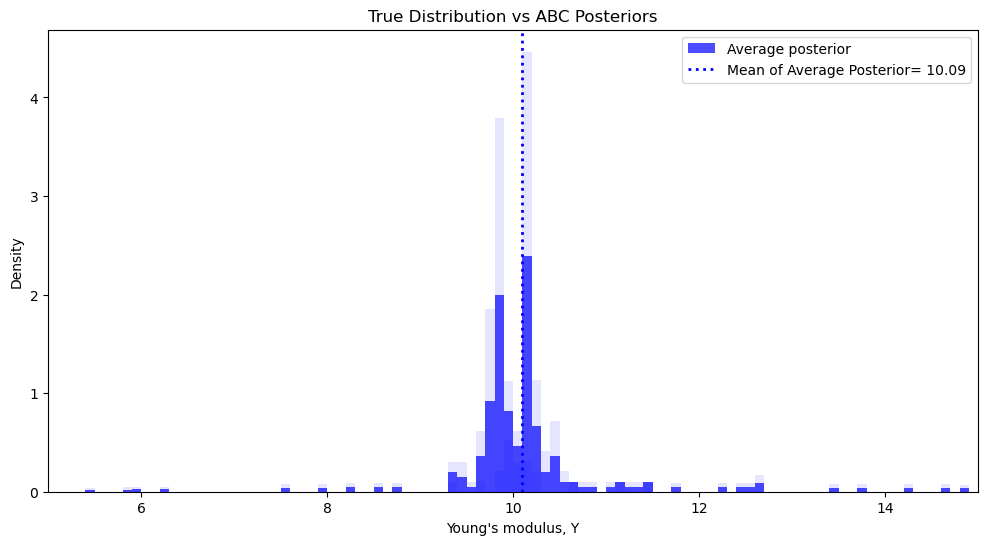

In [27]:
# Plot results
plt.figure(figsize=(12, 6))
bins = 100

# Plot individual experiment posteriors (semi-transparent)
for samples, weights in zip(all_experiment_samples, all_experiment_weights):
    plt.hist(samples, bins=bins, density=True, weights=weights,
             alpha=0.1, color='blue', range=(Y_min, Y_max))

# Plot average posterior
combined_samples = np.concatenate(all_experiment_samples)
combined_weights = np.concatenate(all_experiment_weights) / n_experiments
plt.hist(combined_samples, bins=bins, density=True, weights=combined_weights,
         alpha=0.7, color='blue', range=(Y_min, Y_max),
         label='Average posterior')

# Calculate and plot the mean of the average posterior as a dotted line
mean_posterior = np.mean(combined_samples)
plt.axvline(mean_posterior, color='blue', linestyle='dotted', linewidth=2, label=f'Mean of Average Posterior= {mean_posterior:.2f}')


plt.xlabel("Young's modulus, Y")
plt.ylabel("Density")
plt.title("True Distribution vs ABC Posteriors")
plt.legend()
plt.xlim(Y_min, Y_max)
plt.show();

### Impact of $N_{experiment}$ & noise_sd

In [14]:
# Prior for the Young modulus: Uniform over [Y_min, Y_max]
Y_min, Y_max = 5.0, 15.0

# Use the same Y but with noise for the different experiments
Y_true = 10

Some adapted ABC method.

In [88]:
def ABC_plot_eps(N_experiments, N_trials, noise_mean, noise_sd, epsilon,
                 Y_min=5.0, Y_max=15.0, Y_true=10.0, nu=0.3, P_obs=1.0, U_obs=U_obs, mode = None, plot = 1):
    
    if U_obs is None:
        raise ValueError("U_obs must be provided.")
    
    all_experiment_Y = []
    all_experiment_weights = []
    
    # Run multiple experiments
    for exp in tqdm(range(N_experiments), ncols=100):
        # Generate the noise
        noise = np.random.normal(loc=noise_mean, scale=noise_sd, size=U_obs.vector().get_local().shape)
        
        # Generate synthetic observation with this Y_true
        solve_linear_model(mesh=mesh, boundaries_mf=boundaries_mf, bcs=bcs, U=U, 
                          Y=Y_true, nu=nu, P=P_obs)
        U_obs = df.Function(U.function_space())
        U_obs.assign(U)
        
        # Add noise to simulate real measurement
        U_obs.vector()[:] += noise
        
        # Run ABC for this observation
        all_Y, all_weights_norm = ABC_weighted_rejection(U_obs, Y_min, Y_max, N_trials, noise_mean, noise_sd, epsilon)
        
        all_experiment_Y.append(np.array(all_Y))
        all_experiment_weights.append(np.array(all_weights_norm))
    
    # Flatten the accepted samples and corresponding weights
    all_accepted_Y = np.concatenate(all_experiment_Y)
    all_accepted_weights = np.concatenate(all_experiment_weights)
    
    # Compute weighted mean and standard deviation
    weighted_mean = np.average(all_accepted_Y, weights=all_accepted_weights)
    weighted_variance = np.average((all_accepted_Y - weighted_mean) ** 2, weights=all_accepted_weights)
    weighted_std = np.sqrt(weighted_variance)
    
    if plot == 1:
        # Plot the posterior density with weights
        plt.figure(figsize=(8, 5))
        plt.hist(all_accepted_Y, bins=30, weights=all_accepted_weights, density=True, alpha=0.6, color='b', label='Weighted Posterior Density')
        plt.axvline(Y_true, color='r', linestyle='--', label='True Y')
        plt.axvline(weighted_mean, color='g', linestyle='-', label=f'Mean: {weighted_mean:.2f}')
        plt.xlabel("Y Values")
        plt.ylabel("Density")
        if mode == 1:
            plt.title(f"N_experiment = {N_experiments} & N_trials = {N_trials}")
        else : 
            plt.title("Approximated Posterior Density (Weighted)")
        plt.legend()
        plt.grid(True)
        plt.show()

        print(f"Posterior Mean: {weighted_mean:.2f}")
        print(f"Posterior Standard Deviation: {weighted_std:.2f}")
    
    return weighted_mean

### Lotta runs to see impacts of the parameters

#### Noise and epsilon (large enough) fixed and try to see the impact of $N_{experiments}$ and $N_{trials}$

In [60]:
#Noise parameters (fixed)
noise_mean = 0
noise_sd = 0.01

#epsilon value
epsilon = 0.5


🔹 Exécution avec N_experiments = 5, N_trials = 10



100%|█████████████████████████████████████████████████████████████████| 5/5 [00:07<00:00,  1.49s/it]


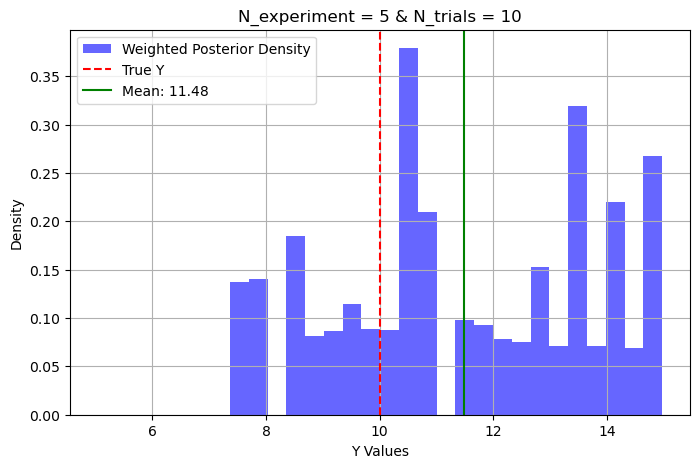

Posterior Mean: 11.48
Posterior Standard Deviation: 2.24

🔹 Exécution avec N_experiments = 5, N_trials = 50



100%|█████████████████████████████████████████████████████████████████| 5/5 [00:35<00:00,  7.14s/it]


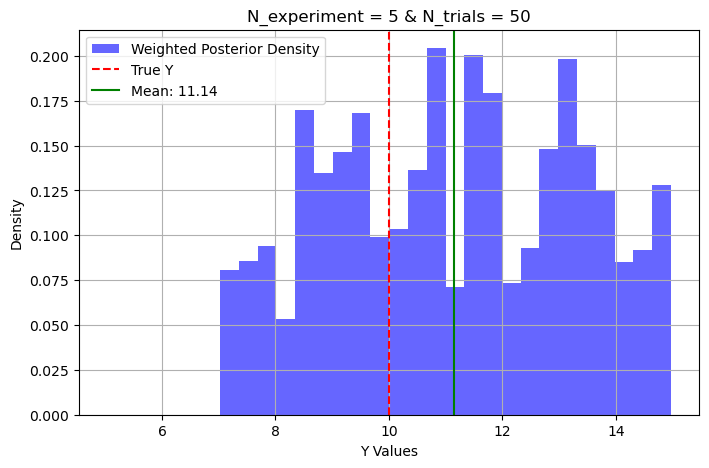

Posterior Mean: 11.14
Posterior Standard Deviation: 2.15

🔹 Exécution avec N_experiments = 5, N_trials = 100



100%|█████████████████████████████████████████████████████████████████| 5/5 [01:11<00:00, 14.23s/it]


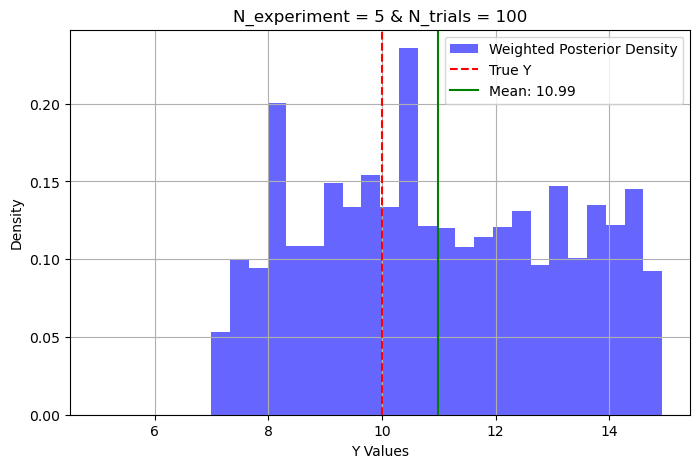

Posterior Mean: 10.99
Posterior Standard Deviation: 2.17

🔹 Exécution avec N_experiments = 20, N_trials = 10



100%|███████████████████████████████████████████████████████████████| 20/20 [00:28<00:00,  1.45s/it]


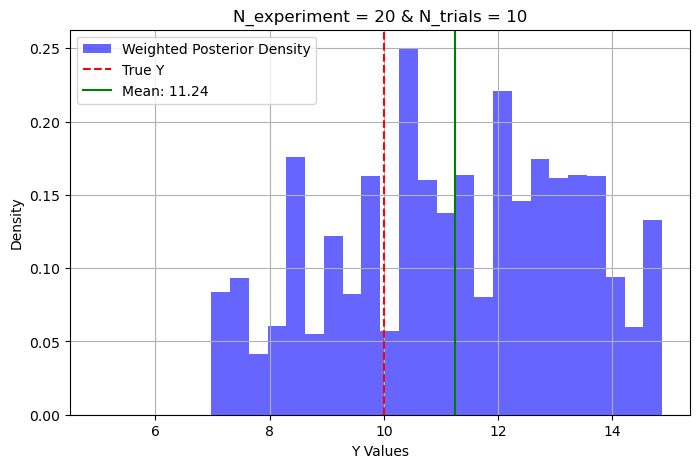

Posterior Mean: 11.24
Posterior Standard Deviation: 2.07

🔹 Exécution avec N_experiments = 20, N_trials = 50



100%|███████████████████████████████████████████████████████████████| 20/20 [02:23<00:00,  7.16s/it]


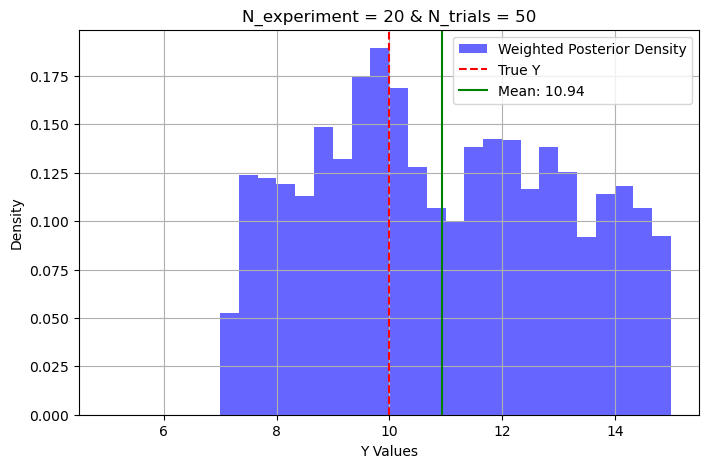

Posterior Mean: 10.94
Posterior Standard Deviation: 2.16

🔹 Exécution avec N_experiments = 20, N_trials = 100



100%|███████████████████████████████████████████████████████████████| 20/20 [04:45<00:00, 14.27s/it]


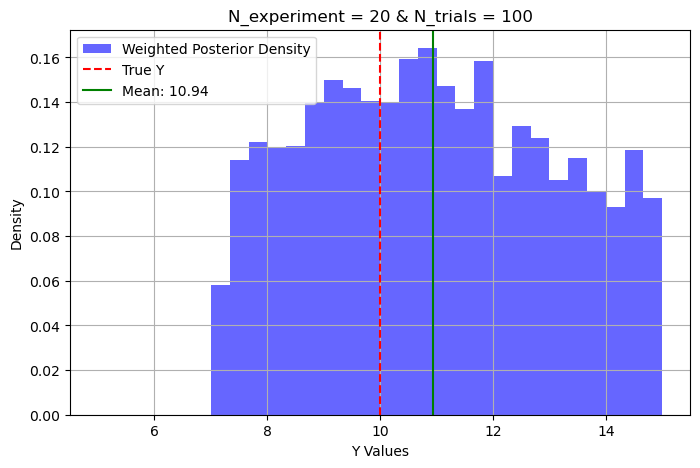

Posterior Mean: 10.94
Posterior Standard Deviation: 2.14

🔹 Exécution avec N_experiments = 50, N_trials = 10



100%|███████████████████████████████████████████████████████████████| 50/50 [01:12<00:00,  1.46s/it]


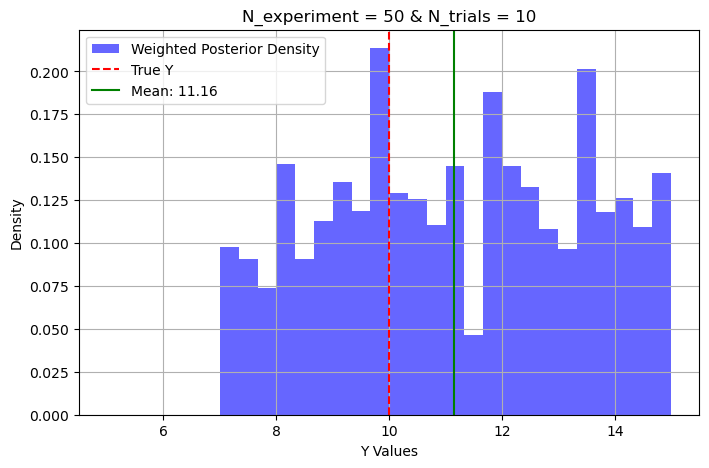

Posterior Mean: 11.16
Posterior Standard Deviation: 2.23

🔹 Exécution avec N_experiments = 50, N_trials = 50



100%|███████████████████████████████████████████████████████████████| 50/50 [05:57<00:00,  7.15s/it]


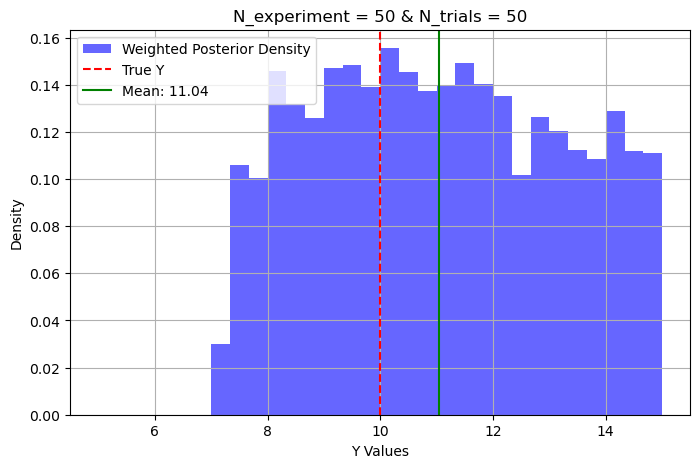

Posterior Mean: 11.04
Posterior Standard Deviation: 2.15

🔹 Exécution avec N_experiments = 50, N_trials = 100



100%|███████████████████████████████████████████████████████████████| 50/50 [11:54<00:00, 14.29s/it]


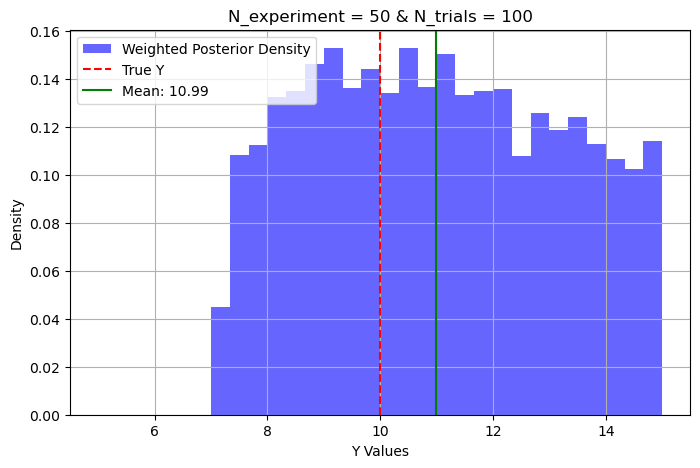

Posterior Mean: 10.99
Posterior Standard Deviation: 2.16


In [62]:
N_experiments_values = [5, 20, 50]   # Différents niveaux d'expériences
N_trials_values = [10, 50, 100]      # Nombre d'essais plus granulaire mais limité à 100

for N_experiments in N_experiments_values:
    for N_trials in N_trials_values:b
        print(f"\n🔹 Exécution avec N_experiments = {N_experiments}, N_trials = {N_trials}\n")
        ABC_plot_eps(N_experiments, N_trials, noise_mean, noise_sd, epsilon, 
                     Y_min, Y_max, Y_true, nu, P_obs, U_obs, mode=1)

#### N_trials and epsilon fixed, we explore the trade off between noise_sd and N_experiments

🔹 Running with N_experiments = 1, noise_sd = 0.05


100%|█████████████████████████████████████████████████████████████████| 1/1 [00:07<00:00,  7.18s/it]


🔹 Running with N_experiments = 1, noise_sd = 0.1


100%|█████████████████████████████████████████████████████████████████| 1/1 [00:07<00:00,  7.24s/it]


🔹 Running with N_experiments = 1, noise_sd = 0.2


100%|█████████████████████████████████████████████████████████████████| 1/1 [00:07<00:00,  7.17s/it]


🔹 Running with N_experiments = 1, noise_sd = 0.3


100%|█████████████████████████████████████████████████████████████████| 1/1 [00:07<00:00,  7.16s/it]


🔹 Running with N_experiments = 1, noise_sd = 0.5


100%|█████████████████████████████████████████████████████████████████| 1/1 [00:07<00:00,  7.14s/it]


🔹 Running with N_experiments = 5, noise_sd = 0.05


100%|█████████████████████████████████████████████████████████████████| 5/5 [00:35<00:00,  7.12s/it]


🔹 Running with N_experiments = 5, noise_sd = 0.1


100%|█████████████████████████████████████████████████████████████████| 5/5 [00:35<00:00,  7.18s/it]


🔹 Running with N_experiments = 5, noise_sd = 0.2


100%|█████████████████████████████████████████████████████████████████| 5/5 [00:35<00:00,  7.13s/it]


🔹 Running with N_experiments = 5, noise_sd = 0.3


100%|█████████████████████████████████████████████████████████████████| 5/5 [00:35<00:00,  7.19s/it]


🔹 Running with N_experiments = 5, noise_sd = 0.5


100%|█████████████████████████████████████████████████████████████████| 5/5 [00:35<00:00,  7.11s/it]


🔹 Running with N_experiments = 10, noise_sd = 0.05


100%|███████████████████████████████████████████████████████████████| 10/10 [01:11<00:00,  7.11s/it]


🔹 Running with N_experiments = 10, noise_sd = 0.1


100%|███████████████████████████████████████████████████████████████| 10/10 [01:11<00:00,  7.15s/it]


🔹 Running with N_experiments = 10, noise_sd = 0.2


100%|███████████████████████████████████████████████████████████████| 10/10 [01:11<00:00,  7.19s/it]


🔹 Running with N_experiments = 10, noise_sd = 0.3


100%|███████████████████████████████████████████████████████████████| 10/10 [01:12<00:00,  7.21s/it]


🔹 Running with N_experiments = 10, noise_sd = 0.5


100%|███████████████████████████████████████████████████████████████| 10/10 [01:12<00:00,  7.24s/it]


🔹 Running with N_experiments = 20, noise_sd = 0.05


100%|███████████████████████████████████████████████████████████████| 20/20 [02:23<00:00,  7.17s/it]


🔹 Running with N_experiments = 20, noise_sd = 0.1


100%|███████████████████████████████████████████████████████████████| 20/20 [02:23<00:00,  7.20s/it]


🔹 Running with N_experiments = 20, noise_sd = 0.2


100%|███████████████████████████████████████████████████████████████| 20/20 [02:23<00:00,  7.17s/it]


🔹 Running with N_experiments = 20, noise_sd = 0.3


100%|███████████████████████████████████████████████████████████████| 20/20 [02:23<00:00,  7.18s/it]


🔹 Running with N_experiments = 20, noise_sd = 0.5


100%|███████████████████████████████████████████████████████████████| 20/20 [02:23<00:00,  7.16s/it]


🔹 Running with N_experiments = 50, noise_sd = 0.05


100%|███████████████████████████████████████████████████████████████| 50/50 [05:58<00:00,  7.17s/it]


🔹 Running with N_experiments = 50, noise_sd = 0.1


100%|███████████████████████████████████████████████████████████████| 50/50 [05:57<00:00,  7.14s/it]


🔹 Running with N_experiments = 50, noise_sd = 0.2


100%|███████████████████████████████████████████████████████████████| 50/50 [05:56<00:00,  7.14s/it]


🔹 Running with N_experiments = 50, noise_sd = 0.3


100%|███████████████████████████████████████████████████████████████| 50/50 [05:57<00:00,  7.15s/it]


🔹 Running with N_experiments = 50, noise_sd = 0.5


100%|███████████████████████████████████████████████████████████████| 50/50 [05:56<00:00,  7.13s/it]


<Figure size 800x600 with 0 Axes>

<AxesSubplot: >

Text(0.5, 36.72222222222221, 'Noise Standard Deviation (noise_sd)')

Text(70.72222222222221, 0.5, 'Number of Experiments (N_experiments)')

Text(0.5, 1.0, 'Heatmap of Error Between Estimated Mean and Y_true')

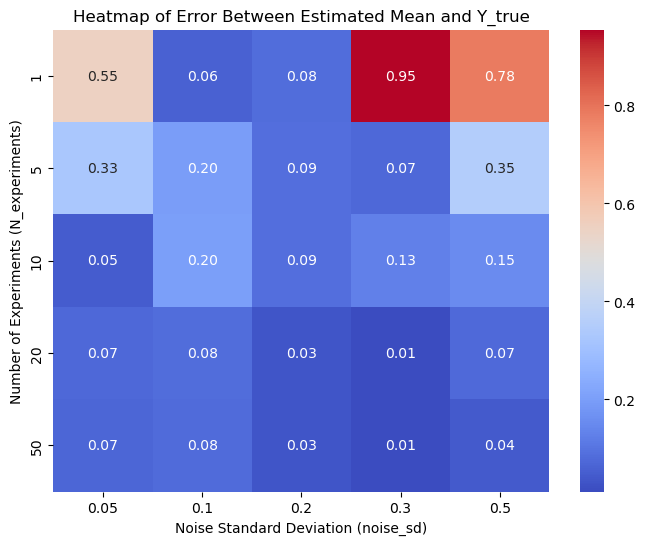

In [90]:
# Parameter values to test
N_experiments_values = [1, 5, 10, 20, 50]  # Different numbers of experiments
noise_sd_values = [0.05, 0.1, 0.2, 0.3, 0.5]  # Different noise levels

# Fixed parameters
N_trials = 50
noise_mean = 0
epsilon = 0.5

# Store results
error_matrix = np.zeros((len(N_experiments_values), len(noise_sd_values)))

# Loop over parameters
for i, N_experiments in enumerate(N_experiments_values):
    for j, noise_sd in enumerate(noise_sd_values):
        print(f"🔹 Running with N_experiments = {N_experiments}, noise_sd = {noise_sd}")

        # Run ABC
        weighted_mean = ABC_plot_eps(N_experiments, N_trials, noise_mean, noise_sd, epsilon, 
                                     Y_min, Y_max, Y_true, nu, P_obs, U_obs, mode=1, plot = 0)

        # Compute absolute error |mean - Y_true|f)
        error_matrix[i, j] = abs(weighted_mean - Y_true)

<Figure size 800x600 with 0 Axes>

<AxesSubplot: >

Text(0.5, 36.72222222222221, 'Noise Standard Deviation (noise_sd)')

Text(70.72222222222221, 0.5, 'Number of Experiments (N_experiments)')

Text(0.5, 1.0, 'Heatmap of Error Between Estimated Mean and Y_true')

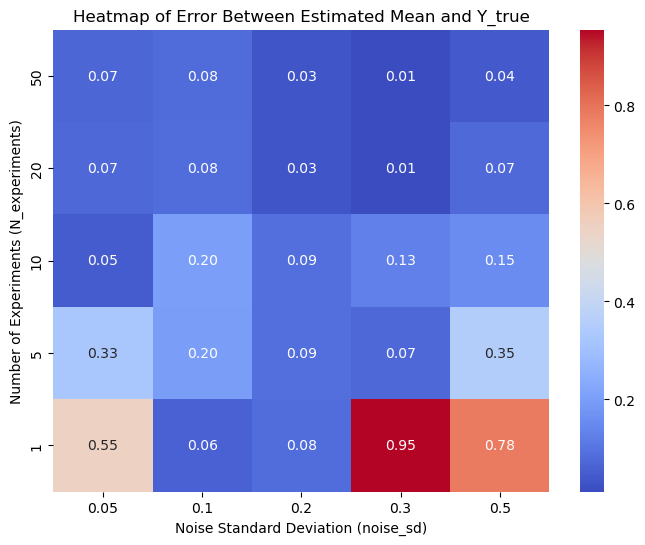

In [94]:
plt.figure(figsize=(8, 6))
sns.heatmap(error_matrix, annot=True, xticklabels=noise_sd_values, yticklabels=N_experiments_values, cmap="coolwarm", fmt=".2f")

# Invert axes
plt.gca().invert_yaxis()  # Invert the y-axis
#plt.gca().invert_xaxis()  # Invert the x-axis

# Labels and title
plt.xlabel("Noise Standard Deviation (noise_sd)")
plt.ylabel("Number of Experiments (N_experiments)")
plt.title("Heatmap of Error Between Estimated Mean and Y_true")

# Save the figure
plt.savefig("heatmap_error.png")  # Save it as PNG or any format you prefer

# Show the plot
plt.show()

Question: How to retrieve the distribution of the noise ?

## Multiple Experiments - true_Y also follows a distribution

Here, we simulate that you have multiple specimen that might be similar. You still run multiple experiments, but only one per specimen. You want to find the distribution of the parameter for this sample of specimen without the measurement noise.

Should converge to the distribution of the Parameters of all the specimen.

We sample measurements (experiments) from a normal distribution and compute their "measured" displacement. Then we do the ABC Algorithm by drawing the Y's from a uniform distribution, and weigh them by their calculated displacements inverse distance to the measurements displacement. Then, we average over all the experiments. There might need to be a better method to combine all the different distributions of the individual specimen.

**But what are we plotting ?**

We can plot the total distribution : all the sampled value and their associated weights.

We can plot consider that each experiment gives us a different posterior distribution and we compute the Wasserstein barycenter of all them and consider it to be our posterior.

**We may be able to use the data from this part and only change the final computation to see the effect of the two differents averaging method.**

In [15]:
# Define the distribution for true_Y
# Let's say it's a normal distribution with mean=10 and std=1, truncated to [Y_min, Y_max]
from scipy.stats import truncnorm

# Parameters for the true Y distribution
Y_true_mean = 10.0
Y_true_std = 1.0
a = (Y_min - Y_true_mean) / Y_true_std  # For truncated normal
b = (Y_max - Y_true_mean) / Y_true_std
true_Y_dist = truncnorm(a, b, loc=Y_true_mean, scale=Y_true_std)

# Prior for the Young modulus: Uniform over [Y_min, Y_max]
Y_min, Y_max = 5.0, 15.0

# Generate the noise
noise_mean = 0
noise_sd = 0.01

### With epsilon rejection of samples

In [129]:
# Number of experiments to run
n_experiments = 100
N_trials = 500
epsilon = 1.11  # acceptance threshold

# Storage for results from all experiments
all_experiment_accepted_Y = []

# Run multiple experiments
for exp in tqdm(range(n_experiments), ncols= 100):
    # Draw a true Y value for this experiment
    true_Y = true_Y_dist.rvs()
    
    # Generate the noise
    noise = np.random.normal(loc=noise_mean, scale=noise_sd, size=U_obs.vector().get_local().shape)
    
    # Generate synthetic observation with this true_Y
    solve_linear_model(mesh=mesh, boundaries_mf=boundaries_mf, bcs=bcs, U=U, 
                      Y=true_Y, nu=nu, P=P_obs)
    U_obs = df.Function(U.function_space())
    U_obs.assign(U)
    
    # Add noise to the model the real measurement
    U_obs.vector()[:] += noise
    
    # Run ABC for this observation
    accepted_Y, _ = ABC_rejection(U_obs, Y_min, Y_max, N_trials, epsilon, noise_mean, noise_sd)

    #print(f"Experiment {exp+1} finished with {len(accepted_Y)} accepted samples")
    all_experiment_accepted_Y.append(np.array(accepted_Y))


100%|█████████████████████████████████████████████████████████████| 100/100 [32:55<00:00, 19.76s/it]


#### Total distribution

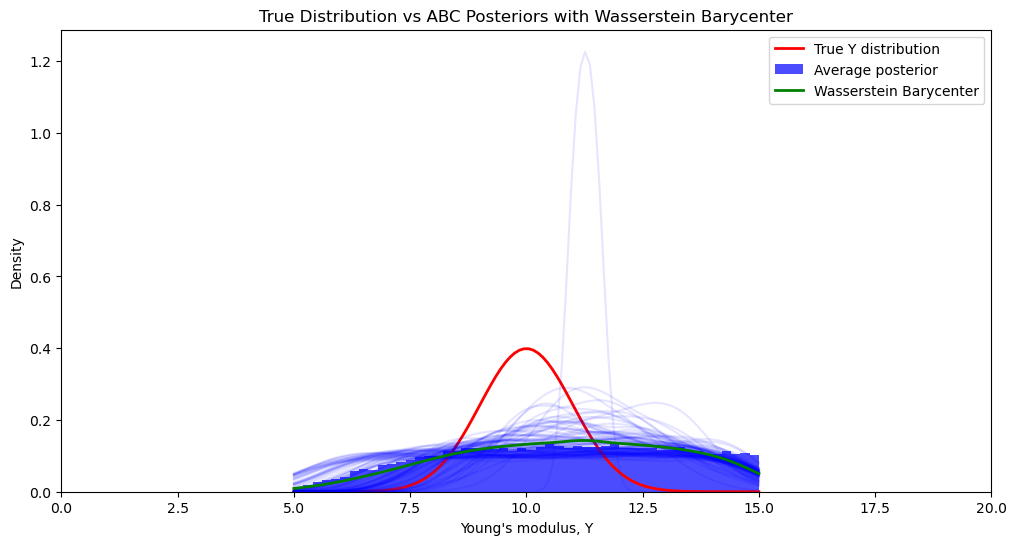

In [130]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import gaussian_kde
import ot  # For Wasserstein distance calculation

# Define a common grid for interpolation (same grid for all distributions)
num_points = 100  # Number of points for interpolation
y_range = np.linspace(Y_min, Y_max, num_points)

#remove one element or less distributions
all_experiment_accepted_Y = [x for x in  all_experiment_accepted_Y if len(x) >1]

# Step 1: Smooth each experiment's posterior distribution using KDE
kde_distributions = []

for accepted_Y in all_experiment_accepted_Y:
    kde = gaussian_kde(accepted_Y)

    # Interpolate the KDE onto the common grid
    kde_values = kde(y_range)
    kde_distributions.append(kde_values)

# Convert the list to a numpy array (shape: num_experiments x num_points)
kde_distributions = np.array(kde_distributions)

# Ensure each distribution is evaluated over the same grid and is the same size
kde_distributions = kde_distributions.T  # Now shape is (num_points, num_experiments)

# Step 2: Use uniform weights for each experiment (you can change this if you need non-uniform weights)
uniform_weights = np.ones(kde_distributions.shape[1]) / kde_distributions.shape[1]

# Step 3: Compute the discrete Wasserstein barycenter using the geometric mean approach
# First, compute pairwise Wasserstein distances
num_experiments = kde_distributions.shape[1]
distances = np.zeros((num_experiments, num_experiments))

# Compute pairwise Wasserstein distances (using discrete approximation)
for i in range(num_experiments):
    for j in range(i + 1, num_experiments):
        # Define the cost matrix M (distance between grid points)
        M = np.abs(np.expand_dims(y_range, axis=1) - np.expand_dims(y_range, axis=0))
        
        # Normalize the distributions (mass for each distribution)
        mass_a = kde_distributions[:, i] / np.sum(kde_distributions[:, i])
        mass_b = kde_distributions[:, j] / np.sum(kde_distributions[:, j])

        # Compute Wasserstein distance between distributions i and j
        dist = ot.emd2(mass_a, mass_b, M)
        distances[i, j] = dist
        distances[j, i] = dist

# Compute the barycenter by averaging distributions weighted by inverse pairwise distances
weights_for_barycenter = 1 / (np.sum(distances, axis=1) + 1e-10)  # Avoid division by zero
weights_for_barycenter /= np.sum(weights_for_barycenter)  # Normalize the weights

# Compute the weighted average of the distributions
wasserstein_barycenter = np.dot(kde_distributions, weights_for_barycenter)

# Plotting the results
plt.figure(figsize=(12, 6))
bins = 50

# Plot the true Y distribution (if available)
plt.plot(y_range, true_Y_dist.pdf(y_range), 'r-', label='True Y distribution', linewidth=2)

# Plot each experiment's KDE smoothed posterior
for accepted_Y in all_experiment_accepted_Y:
    kde = gaussian_kde(accepted_Y)
    kde_values = kde(y_range)
    plt.plot(y_range, kde_values, alpha=0.1, color='blue')

# Compute and normalize the weighted average posterior
combined_samples = np.concatenate(all_experiment_accepted_Y)
combined_weights = np.ones(combined_samples.shape)  # Assuming equal weight for each sample
combined_weights /= np.sum(combined_weights)

# Plot the weighted average posterior
plt.hist(combined_samples, bins=bins, density=True, weights=combined_weights,
         alpha=0.7, color='blue', range=(Y_min, Y_max),
         label='Average posterior')

# Plot the Wasserstein barycenter
plt.plot(y_range, wasserstein_barycenter, 'g-', linewidth=2, label='Wasserstein Barycenter')

# Finalize the plot
plt.xlabel("Young's modulus, Y")
plt.ylabel("Density")
plt.title("True Distribution vs ABC Posteriors with Wasserstein Barycenter")
plt.legend()
plt.xlim(Y_min - 5, Y_max + 5)
plt.show();

### With Distance based weighing of samples

In [131]:
# Generate the noise
noise_mean = 0
noise_sd = 0.05

# Number of experiments & trials to run
n_experiments = 100
N_trials = 500

# Storage for results from all experiments
all_experiment_samples = []
all_experiment_weights = []

# Run multiple experiments
for exp in tqdm(range(n_experiments), ncols= 100):
    # Draw a true Y value for this experiment
    true_Y = true_Y_dist.rvs()

    # Generate the noise
    noise = np.random.normal(loc=noise_mean, scale=noise_sd, size=U_obs.vector().get_local().shape)
    
    # Generate synthetic observation with this true_Y
    solve_linear_model(mesh=mesh, boundaries_mf=boundaries_mf, bcs=bcs, U=U, 
                      Y=true_Y, nu=nu, P=P_obs)
    U_obs = df.Function(U.function_space())
    U_obs.assign(U)
    
    # Add noise
    U_obs.vector()[:] += noise

    
    # Run ABC for this observation
    all_samples, all_weights_norm = ABC_weighted(U_obs, Y_min, Y_max, N_trials, noise_mean, noise_sd)
    
    # Store results
    all_experiment_samples.append(np.array(all_samples))
    all_experiment_weights.append(all_weights_norm)

100%|█████████████████████████████████████████████████████████████| 100/100 [33:08<00:00, 19.89s/it]


<Figure size 1200x600 with 0 Axes>

(array([0.09152048, 0.09740774, 0.0946037 , 0.08956175, 0.09319666,
        0.09044078, 0.09323111, 0.09980897, 0.10270921, 0.09840018,
        0.10122505, 0.09708859, 0.09895126, 0.09875646, 0.10379156,
        0.10405116, 0.10047613, 0.10404741, 0.10006608, 0.10749538,
        0.09969082, 0.09869979, 0.10065437, 0.10404063, 0.10637337,
        0.10560079, 0.10302052, 0.1005767 , 0.10834291, 0.10168189,
        0.10102476, 0.09788583, 0.10054146, 0.09941575, 0.104798  ,
        0.09898301, 0.103419  , 0.10014644, 0.09664716, 0.1067379 ,
        0.09883028, 0.10105074, 0.1020066 , 0.09902699, 0.10090143,
        0.10099968, 0.1006253 , 0.0937908 , 0.10076451, 0.09689289]),
 array([ 5. ,  5.2,  5.4,  5.6,  5.8,  6. ,  6.2,  6.4,  6.6,  6.8,  7. ,
         7.2,  7.4,  7.6,  7.8,  8. ,  8.2,  8.4,  8.6,  8.8,  9. ,  9.2,
         9.4,  9.6,  9.8, 10. , 10.2, 10.4, 10.6, 10.8, 11. , 11.2, 11.4,
        11.6, 11.8, 12. , 12.2, 12.4, 12.6, 12.8, 13. , 13.2, 13.4, 13.6,
        13.8, 14. , 14

Text(0.5, 0, "Young's modulus, Y")

Text(0, 0.5, 'Density')

Text(0.5, 1.0, 'True Distribution vs ABC Posteriors with Wasserstein Barycenter')

(0.0, 20.0)

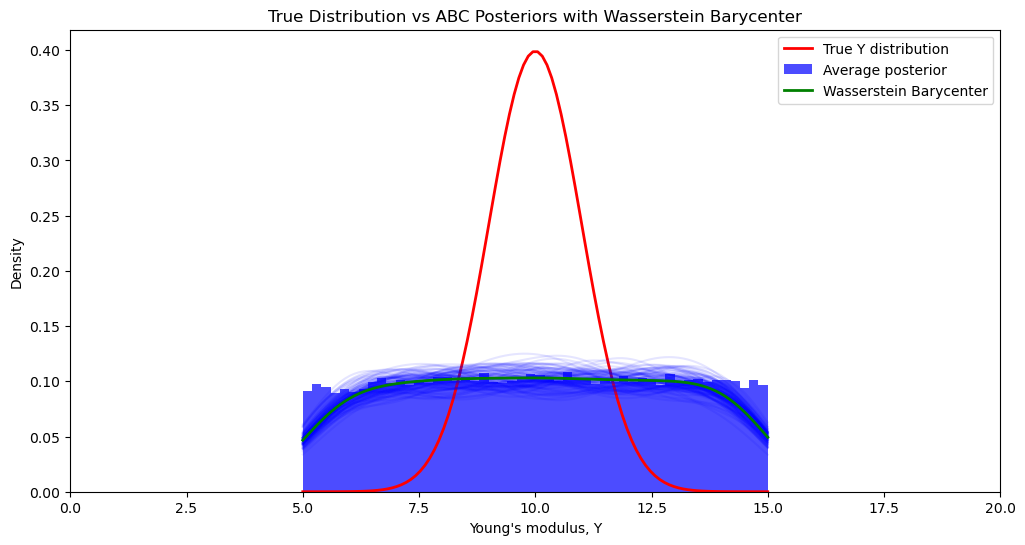

In [132]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import gaussian_kde
import ot  # For Wasserstein distance calculation

# Define a common grid for interpolation (same grid for all distributions)
num_points = 100  # Number of points for interpolation
y_range = np.linspace(Y_min, Y_max, num_points)

# Step 1: Smooth each experiment's posterior distribution using KDE
kde_distributions = []
for samples, weights in zip(all_experiment_samples, all_experiment_weights):
    kde = gaussian_kde(samples, weights=weights)
    
    # Interpolate the KDE onto the common grid
    kde_values = kde(y_range)
    kde_distributions.append(kde_values)

# Convert the list to a numpy array (shape: num_experiments x num_points)
kde_distributions = np.array(kde_distributions)

# Ensure each distribution is evaluated over the same grid and is the same size
kde_distributions = kde_distributions.T  # Now shape is (num_points, num_experiments)

# Step 2: Use uniform weights for each experiment (you can change this if you need non-uniform weights)
uniform_weights = np.ones(kde_distributions.shape[1]) / kde_distributions.shape[1]

# Step 3: Compute the discrete Wasserstein barycenter using the geometric mean approach
# First, compute pairwise Wasserstein distances
num_experiments = kde_distributions.shape[1]
distances = np.zeros((num_experiments, num_experiments))

# Compute pairwise Wasserstein distances (using discrete approximation)
for i in range(num_experiments):
    for j in range(i + 1, num_experiments):
        # Define the cost matrix M (distance between grid points)
        M = np.abs(np.expand_dims(y_range, axis=1) - np.expand_dims(y_range, axis=0))
        
        # Normalize the distributions (mass for each distribution)
        mass_a = kde_distributions[:, i] / np.sum(kde_distributions[:, i])
        mass_b = kde_distributions[:, j] / np.sum(kde_distributions[:, j])

        # Compute Wasserstein distance between distributions i and j
        dist = ot.emd2(mass_a, mass_b, M)
        distances[i, j] = dist
        distances[j, i] = dist

# Compute the barycenter by averaging distributions weighted by inverse pairwise distances
weights_for_barycenter = 1 / (np.sum(distances, axis=1) + 1e-10)  # Avoid division by zero
weights_for_barycenter /= np.sum(weights_for_barycenter)  # Normalize the weights

# Compute the weighted average of the distributions
wasserstein_barycenter = np.dot(kde_distributions, weights_for_barycenter)

# Plotting the results
plt.figure(figsize=(12, 6))
bins = 50

# Plot the true Y distribution (if available)
plt.plot(y_range, true_Y_dist.pdf(y_range), 'r-', label='True Y distribution', linewidth=2)

# Plot each experiment's KDE smoothed posterior
for samples, weights in zip(all_experiment_samples, all_experiment_weights):
    kde = gaussian_kde(samples, weights=weights)
    kde_values = kde(y_range)
    plt.plot(y_range, kde_values, alpha=0.1, color='blue')

# Compute and normalize the weighted average posterior
combined_samples = np.concatenate(all_experiment_samples)
combined_weights = np.concatenate(all_experiment_weights)
combined_weights /= np.sum(combined_weights)

# Plot the weighted average posterior
plt.hist(combined_samples, bins=bins, density=True, weights=combined_weights,
         alpha=0.7, color='blue', range=(Y_min, Y_max),
         label='Average posterior')

# Plot the Wasserstein barycenter
plt.plot(y_range, wasserstein_barycenter, 'g-', linewidth=2, label='Wasserstein Barycenter')

# Finalize the plot
plt.xlabel("Young's modulus, Y")
plt.ylabel("Density")
plt.title("True Distribution vs ABC Posteriors with Wasserstein Barycenter")
plt.legend()
plt.xlim(Y_min - 5, Y_max + 5)
plt.show()


#### Total distribution

<Figure size 1200x600 with 0 Axes>

ValueError: shapes (20,) and (100,20) not aligned: 20 (dim 0) != 100 (dim 0)

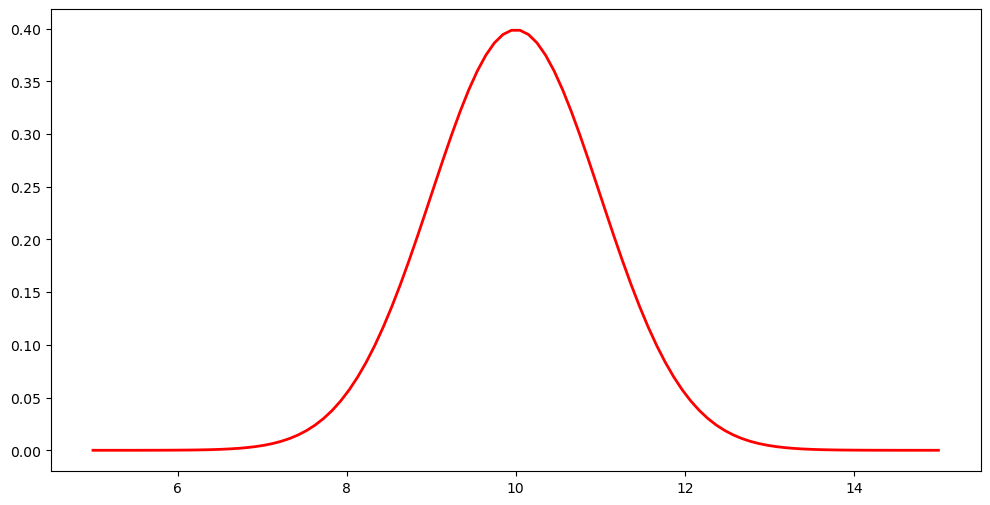

In [60]:
# Set up figure
plt.figure(figsize=(12, 6))
bins = 50

# Plot the true Y distribution
y_range = np.linspace(Y_min, Y_max, 100)
plt.plot(y_range, true_Y_dist.pdf(y_range), 'r-', label='True Y distribution', linewidth=2)

# Smooth each experiment's posterior using KDE
kde_distributions = []
kde_weights = []

for samples, weights in zip(all_experiment_samples, all_experiment_weights):
    kde = gaussian_kde(samples, weights=weights)
    kde_distributions.append(kde(y_range))  # Store PDF values
    kde_weights.append(1.0 / n_experiments)  # Equal weights for barycenter

# Compute Wasserstein Barycenter using Sinkhorn
kde_distributions = np.array(kde_distributions).T  # Shape (num_points, num_experiments)
# Regularization parameter 'reg' should be set correctly
wasserstein_barycenter = barycenter_sinkhorn(kde_distributions, np.array(kde_weights), reg=1e-2)

# Plot individual experiment posteriors (semi-transparent)
for samples, weights in zip(all_experiment_samples, all_experiment_weights):
    plt.hist(samples, bins=bins, density=True, weights=weights,
             alpha=0.1, color='blue', range=(Y_min, Y_max))

# Compute and normalize the combined posterior
combined_samples = np.concatenate(all_experiment_samples)
combined_weights = np.concatenate(all_experiment_weights)
combined_weights /= np.sum(combined_weights)

# Plot the weighted average posterior
plt.hist(combined_samples, bins=bins, density=True, weights=combined_weights,
         alpha=0.7, color='blue', range=(Y_min, Y_max),
         label='Average posterior')

# Plot Wasserstein barycenter
plt.plot(y_range, wasserstein_barycenter, 'g-', linewidth=2, label='Wasserstein Barycenter')

# Finalize plot
plt.xlabel("Young's modulus, Y")
plt.ylabel("Density")
plt.title("True Distribution vs ABC Posteriors with Wasserstein Barycenter")
plt.legend()
plt.xlim(Y_min - 5, Y_max + 5)
plt.show()

### Smarter Bounding (as last year)

Reducing the bounds of epsilon as we go.

In [127]:
# Number of experiments & trials to run
n_experiments = 50
Y_tilde = 10
eps = 5
N_steps = 20
N_trials = 100

# Storage for results from all experiments
all_experiment_samples = []
all_experiment_weights = []

# Run multiple experiments
for exp in tqdm(range(n_experiments), ncols= 100):
    # Draw a true Y value for this experiment
    true_Y = true_Y_dist.rvs()
    
    # Generate the noise
    noise = np.random.normal(loc=noise_mean, scale=noise_sd, size=U_obs.vector().get_local().shape)
    
    # Generate synthetic observation with this true_Y
    solve_linear_model(mesh=mesh, boundaries_mf=boundaries_mf, bcs=bcs, U=U, 
                      Y=true_Y, nu=nu, P=P_obs)
    U_obs = df.Function(U.function_space())
    U_obs.assign(U)
    
    # Add noise
    U_obs.vector()[:] += noise
    
    # Run ABC for this observation
    all_Y_samples, all_weights_norm = ABC_half_rejection_method(U_obs, Y_tilde, eps, N_steps, N_trials, noise_mean, noise_sd)
    
    # Store results
    all_experiment_samples.append(all_Y_samples)
    all_experiment_weights.append(all_weights_norm)
    

100%|█████████████████████████████████████████████████████████████| 50/50 [1:10:53<00:00, 85.06s/it]


<Figure size 1200x600 with 0 Axes>

(array([0.00373076, 0.00468154, 0.00417007, 0.00440023, 0.00466472,
        0.00501226, 0.00471326, 0.00430888, 0.00468407, 0.006074  ,
        0.00678792, 0.00935645, 0.01446056, 0.02051814, 0.03419209,
        0.05037472, 0.07200331, 0.09921867, 0.12396896, 0.14630926,
        0.17678892, 0.19964865, 0.21938095, 0.23591858, 0.24949827,
        0.26470855, 0.26563502, 0.26387992, 0.25910065, 0.25706377,
        0.23843906, 0.22021481, 0.20728849, 0.1948118 , 0.17794284,
        0.16123986, 0.14593807, 0.12511339, 0.1071724 , 0.0907718 ,
        0.07365125, 0.06159797, 0.04820449, 0.03394098, 0.02900672,
        0.02244951, 0.01777273, 0.01375541, 0.0090818 , 0.00635343]),
 array([ 5. ,  5.2,  5.4,  5.6,  5.8,  6. ,  6.2,  6.4,  6.6,  6.8,  7. ,
         7.2,  7.4,  7.6,  7.8,  8. ,  8.2,  8.4,  8.6,  8.8,  9. ,  9.2,
         9.4,  9.6,  9.8, 10. , 10.2, 10.4, 10.6, 10.8, 11. , 11.2, 11.4,
        11.6, 11.8, 12. , 12.2, 12.4, 12.6, 12.8, 13. , 13.2, 13.4, 13.6,
        13.8, 14. , 14

Text(0.5, 0, "Young's modulus, Y")

Text(0, 0.5, 'Density')

Text(0.5, 1.0, 'True Distribution vs ABC Posteriors with Wasserstein Barycenter')

(0.0, 20.0)

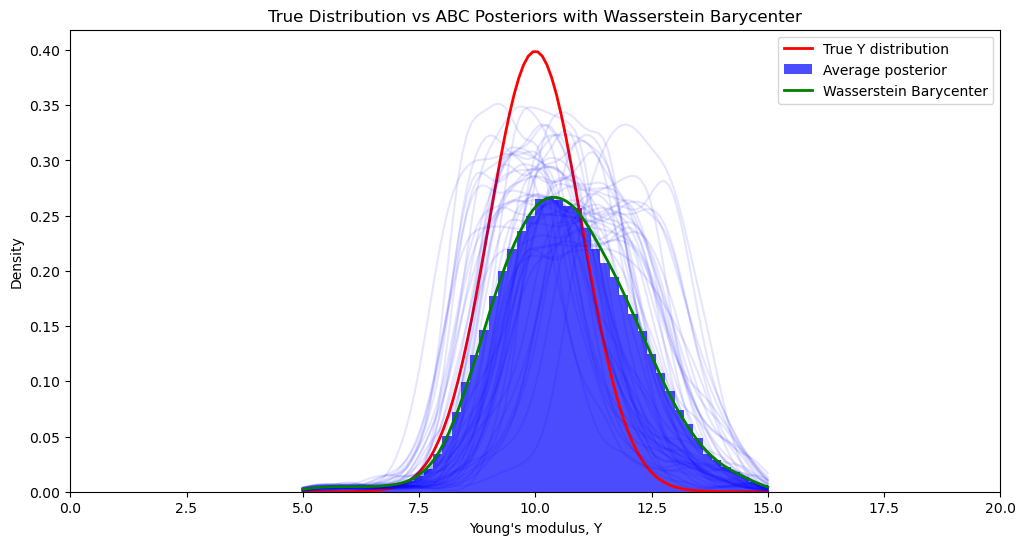

In [128]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import gaussian_kde
import ot  # For Wasserstein distance calculation

# Define a common grid for interpolation (same grid for all distributions)
num_points = 100  # Number of points for interpolation
y_range = np.linspace(Y_min, Y_max, num_points)

# Step 1: Smooth each experiment's posterior distribution using KDE
kde_distributions = []
for samples, weights in zip(all_experiment_samples, all_experiment_weights):
    kde = gaussian_kde(samples, weights=weights)
    
    # Interpolate the KDE onto the common grid
    kde_values = kde(y_range)
    kde_distributions.append(kde_values)

# Convert the list to a numpy array (shape: num_experiments x num_points)
kde_distributions = np.array(kde_distributions)

# Ensure each distribution is evaluated over the same grid and is the same size
kde_distributions = kde_distributions.T  # Now shape is (num_points, num_experiments)

# Step 2: Use uniform weights for each experiment (you can change this if you need non-uniform weights)
uniform_weights = np.ones(kde_distributions.shape[1]) / kde_distributions.shape[1]

# Step 3: Compute the discrete Wasserstein barycenter using the geometric mean approach
# First, compute pairwise Wasserstein distances
num_experiments = kde_distributions.shape[1]
distances = np.zeros((num_experiments, num_experiments))

# Compute pairwise Wasserstein distances (using discrete approximation)
for i in range(num_experiments):
    for j in range(i + 1, num_experiments):
        # Define the cost matrix M (distance between grid points)
        M = np.abs(np.expand_dims(y_range, axis=1) - np.expand_dims(y_range, axis=0))
        
        # Normalize the distributions (mass for each distribution)
        mass_a = kde_distributions[:, i] / np.sum(kde_distributions[:, i])
        mass_b = kde_distributions[:, j] / np.sum(kde_distributions[:, j])

        # Compute Wasserstein distance between distributions i and j
        dist = ot.emd2(mass_a, mass_b, M)
        distances[i, j] = dist
        distances[j, i] = dist

# Compute the barycenter by averaging distributions weighted by inverse pairwise distances
weights_for_barycenter = 1 / (np.sum(distances, axis=1) + 1e-10)  # Avoid division by zero
weights_for_barycenter /= np.sum(weights_for_barycenter)  # Normalize the weights

# Compute the weighted average of the distributions
wasserstein_barycenter = np.dot(kde_distributions, weights_for_barycenter)

# Plotting the results
plt.figure(figsize=(12, 6))
bins = 50

# Plot the true Y distribution (if available)
plt.plot(y_range, true_Y_dist.pdf(y_range), 'r-', label='True Y distribution', linewidth=2)

# Plot each experiment's KDE smoothed posterior
for samples, weights in zip(all_experiment_samples, all_experiment_weights):
    kde = gaussian_kde(samples, weights=weights)
    kde_values = kde(y_range)
    plt.plot(y_range, kde_values, alpha=0.1, color='blue')

# Compute and normalize the weighted average posterior
combined_samples = np.concatenate(all_experiment_samples)
combined_weights = np.concatenate(all_experiment_weights)
combined_weights /= np.sum(combined_weights)

# Plot the weighted average posterior
plt.hist(combined_samples, bins=bins, density=True, weights=combined_weights,
         alpha=0.7, color='blue', range=(Y_min, Y_max),
         label='Average posterior')

# Plot the Wasserstein barycenter
plt.plot(y_range, wasserstein_barycenter, 'g-', linewidth=2, label='Wasserstein Barycenter')

# Finalize the plot
plt.xlabel("Young's modulus, Y")
plt.ylabel("Density")
plt.title("True Distribution vs ABC Posteriors with Wasserstein Barycenter")
plt.legend()
plt.xlim(Y_min - 5, Y_max + 5)
plt.show()

In [24]:
# Number of experiments & trials to run
n_experiments = 50
Y_tilde = 10
eps = 5
N_steps = 50
N_trials = 100

# Storage for results from all experiments
all_experiment_samples = []
all_experiment_weights = []

# Run multiple experiments
for exp in tqdm(range(n_experiments), ncols= 100):
    # Draw a true Y value for this experiment
    true_Y = true_Y_dist.rvs()
    
    # Generate the noise
    noise = np.random.normal(loc=noise_mean, scale=noise_sd, size=U_obs.vector().get_local().shape)
    
    # Generate synthetic observation with this true_Y
    solve_linear_model(mesh=mesh, boundaries_mf=boundaries_mf, bcs=bcs, U=U, 
                      Y=true_Y, nu=nu, P=P_obs)
    U_obs = df.Function(U.function_space())
    U_obs.assign(U)
    
    # Add noise
    U_obs.vector()[:] += noise
    
    # Run ABC for this observation
    all_Y_samples, all_weights_norm = ABC_half_rejection_method(U_obs, Y_tilde, eps, N_steps, N_trials, noise_mean, noise_sd)
    
    # Store results
    all_experiment_samples.append(all_Y_samples)
    all_experiment_weights.append(all_weights_norm)
    

  0%|                                                                        | 0/50 [00:00<?, ?it/s]

Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.


 96%|████████████████████████████████████████████████████████▋  | 48/50 [11:03:37<27:39, 829.54s/it]


KeyboardInterrupt: 

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import gaussian_kde
import ot  # For Wasserstein distance calculation

# Define a common grid for interpolation (same grid for all distributions)
num_points = 100  # Number of points for interpolation
y_range = np.linspace(Y_min, Y_max, num_points)

# Step 1: Smooth each experiment's posterior distribution using KDE
kde_distributions = []
for samples, weights in zip(all_experiment_samples, all_experiment_weights):
    kde = gaussian_kde(samples, weights=weights)
    
    # Interpolate the KDE onto the common grid
    kde_values = kde(y_range)
    kde_distributions.append(kde_values)

# Convert the list to a numpy array (shape: num_experiments x num_points)
kde_distributions = np.array(kde_distributions)

# Ensure each distribution is evaluated over the same grid and is the same size
kde_distributions = kde_distributions.T  # Now shape is (num_points, num_experiments)

# Step 2: Use uniform weights for each experiment (you can change this if you need non-uniform weights)
uniform_weights = np.ones(kde_distributions.shape[1]) / kde_distributions.shape[1]

# Step 3: Compute the discrete Wasserstein barycenter using the geometric mean approach
# First, compute pairwise Wasserstein distances
num_experiments = kde_distributions.shape[1]
distances = np.zeros((num_experiments, num_experiments))

# Compute pairwise Wasserstein distances (using discrete approximation)
for i in range(num_experiments):
    for j in range(i + 1, num_experiments):
        # Define the cost matrix M (distance between grid points)
        M = np.abs(np.expand_dims(y_range, axis=1) - np.expand_dims(y_range, axis=0))
        
        # Normalize the distributions (mass for each distribution)
        mass_a = kde_distributions[:, i] / np.sum(kde_distributions[:, i])
        mass_b = kde_distributions[:, j] / np.sum(kde_distributions[:, j])

        # Compute Wasserstein distance between distributions i and j
        dist = ot.emd2(mass_a, mass_b, M)
        distances[i, j] = dist
        distances[j, i] = dist

# Compute the barycenter by averaging distributions weighted by inverse pairwise distances
weights_for_barycenter = 1 / (np.sum(distances, axis=1) + 1e-10)  # Avoid division by zero
weights_for_barycenter /= np.sum(weights_for_barycenter)  # Normalize the weights

# Compute the weighted average of the distributions
wasserstein_barycenter = np.dot(kde_distributions, weights_for_barycenter)

# Plotting the results
plt.figure(figsize=(12, 6))
bins = 50

# Plot the true Y distribution (if available)
plt.plot(y_range, true_Y_dist.pdf(y_range), 'r-', label='True Y distribution', linewidth=2)

# Plot each experiment's KDE smoothed posterior
for samples, weights in zip(all_experiment_samples, all_experiment_weights):
    kde = gaussian_kde(samples, weights=weights)
    kde_values = kde(y_range)
    plt.plot(y_range, kde_values, alpha=0.1, color='blue')

# Compute and normalize the weighted average posterior
combined_samples = np.concatenate(all_experiment_samples)
combined_weights = np.concatenate(all_experiment_weights)
combined_weights /= np.sum(combined_weights)

# Plot the weighted average posterior
plt.hist(combined_samples, bins=bins, density=True, weights=combined_weights,
         alpha=0.7, color='blue', range=(Y_min, Y_max),
         label='Average posterior')

# Plot the Wasserstein barycenter
plt.plot(y_range, wasserstein_barycenter, 'g-', linewidth=2, label='Wasserstein Barycenter')

# Finalize the plot
plt.xlabel("Young's modulus, Y")
plt.ylabel("Density")
plt.title("True Distribution vs ABC Posteriors with Wasserstein Barycenter")
plt.legend()
plt.xlim(Y_min - 5, Y_max + 5)
plt.show();

### Adapting the sampling distribution from one experiment to another

The big idea here is to change the prior sampling distribution as we go.

You start with the uniform distribution over $[Y_{min},Y_{max}]$ at $N_{experiment} = 0$.
You run the ABC method with it and you get a distribution. You smooth is out using a kernel-based approach.

You then increase $N_{experiment}$ and do the same thing but with the sampling - prior - distribution being the posterior one from the previous experiment.

In [106]:
def ABC_adaptative(U_obs, prior_distribution, N_trials, noise_mean, noise_sd, epsilon, first_experiment = False,**kwargs):
    accepted_Y = []
    accepted_distances = []
    
    if first_experiment:
        
        Y_min = kwargs.get('Y_min')
        Y_max = kwargs.get('Y_max')

        if Y_min is None or Y_max is None:
            raise ValueError("Y_min and Y_max must be provided in kwargs when first_experiment=True")
            
        for i in range(N_trials):
            # Sample Y from the uniform prior
            Y_sample = np.random.uniform(Y_min,Y_max)

            # Solve the forward model with the sampled Young modulus
            # Note: use init_U=True to reinitialize the displacement field at each iteration.
            #solve_nonlinear_model(mesh=mesh, boundaries_mf=boundaries_mf, bcs=bcs, U=U, Y=Y_sample, nu=nu, P=P_obs, init_U=True)
            solve_linear_model(mesh=mesh, boundaries_mf=boundaries_mf, bcs=bcs, U=U, Y=Y_sample, nu=nu, P=P_obs, init_U=True)

            # Generate the noise 
            U.vector()[:] += numpy.random.normal(loc=noise_mean, scale=noise_sd, size=U.vector().get_local().shape)

            # Compute the discrepancy between the current simulation and the observed data
            d = compute_distance(U, U_obs)

            # Accept the sample if the error is below the threshold epsilon
            if d < epsilon:
                accepted_Y.append(Y_sample)
                accepted_distances.append(d)

                #print(f"Accepted {i}: Y_sample = {Y_sample:.3f}, distance = {d:.3f}")
            #else:
                #print(f"Rejected {i}: Y_sample = {Y_sample:.3f}, distance = {d:.3f}")

            #print("Number of accepted samples:", len(accepted_Y))

        return accepted_Y, accepted_distances    

    else :
        for i in range(N_trials):
            
            # Sample Y from the prior
            Y_sample = prior_distribution.resample(1)[0][0]

            # Solve the forward model with the sampled Young modulus
            # Note: use init_U=True to reinitialize the displacement field at each iteration.
            #solve_nonlinear_model(mesh=mesh, boundaries_mf=boundaries_mf, bcs=bcs, U=U, Y=Y_sample, nu=nu, P=P_obs, init_U=True)
            solve_linear_model(mesh=mesh, boundaries_mf=boundaries_mf, bcs=bcs, U=U, Y=Y_sample, nu=nu, P=P_obs, init_U=True)

            # Generate the noise 
            U.vector()[:] += numpy.random.normal(loc=noise_mean, scale=noise_sd, size=U.vector().get_local().shape)

            # Compute the discrepancy between the current simulation and the observed data
            d = compute_distance(U, U_obs)

            # Accept the sample if the error is below the threshold epsilon
            if d < epsilon:
                accepted_Y.append(Y_sample)
                accepted_distances.append(d)
        
        # Final
        print(len(accepted_Y))
        accepted_Y = np.array(accepted_Y)
        accepted_distances = np.array(accepted_distances)
        print(accepted_distances)
        
        # Compute normalized Gaussian weights
        std_dist = np.std(accepted_distances)

        if len(accepted_distances) == 0:
            return [], []  # Avoid NaNs if no samples were accepted

        if std_dist == 0:  # Avoid division by zero if all distances are identical
            gaussian_weights_norm = np.ones_like(accepted_distances) / len(accepted_distances)
        else:
            gaussian_weights = np.exp(-0.5 * (accepted_distances / std_dist) ** 2)

            sum_weights = np.sum(gaussian_weights)
            if sum_weights == 0:  # Avoid division by zero
                gaussian_weights_norm = np.ones_like(accepted_distances) / len(accepted_distances)
            else:
                gaussian_weights_norm = gaussian_weights / sum_weights

        #print(gaussian_weights_norm)
        
            
    return accepted_Y, gaussian_weights_norm 

In [110]:
def ABC_adaptative(U_obs, prior_distribution, N_trials, noise_mean, noise_sd, epsilon, first_experiment=False, **kwargs):
    accepted_Y = []
    accepted_distances = []
    
    if first_experiment:
        
        Y_min = kwargs.get('Y_min')
        Y_max = kwargs.get('Y_max')

        if Y_min is None or Y_max is None:
            raise ValueError("Y_min and Y_max must be provided in kwargs when first_experiment=True")
            
        for i in range(N_trials):
            # Sample Y from the uniform prior
            Y_sample = np.random.uniform(Y_min, Y_max)

            # Solve the forward model with the sampled Young modulus
            # Note: use init_U=True to reinitialize the displacement field at each iteration.
            # solve_nonlinear_model(mesh=mesh, boundaries_mf=boundaries_mf, bcs=bcs, U=U, Y=Y_sample, nu=nu, P=P_obs, init_U=True)
            solve_linear_model(mesh=mesh, boundaries_mf=boundaries_mf, bcs=bcs, U=U, Y=Y_sample, nu=nu, P=P_obs, init_U=True)

            # Generate the noise 
            U.vector()[:] += np.random.normal(loc=noise_mean, scale=noise_sd, size=U.vector().get_local().shape)

            # Compute the discrepancy between the current simulation and the observed data
            d = compute_distance(U, U_obs)

            # Accept the sample if the error is below the threshold epsilon
            if d < epsilon:
                accepted_Y.append(Y_sample)
                accepted_distances.append(d)

        return accepted_Y, accepted_distances    

    else:
        for i in range(N_trials):
            # Sample Y from the prior
            Y_sample = prior_distribution.resample(1)[0][0]

            # Solve the forward model with the sampled Young modulus
            # Note: use init_U=True to reinitialize the displacement field at each iteration.
            # solve_nonlinear_model(mesh=mesh, boundaries_mf=boundaries_mf, bcs=bcs, U=U, Y=Y_sample, nu=nu, P=P_obs, init_U=True)
            solve_linear_model(mesh=mesh, boundaries_mf=boundaries_mf, bcs=bcs, U=U, Y=Y_sample, nu=nu, P=P_obs, init_U=True)

            # Generate the noise 
            U.vector()[:] += np.random.normal(loc=noise_mean, scale=noise_sd, size=U.vector().get_local().shape)

            # Compute the discrepancy between the current simulation and the observed data
            d = compute_distance(U, U_obs)

            # Accept the sample if the error is below the threshold epsilon
            if d < epsilon:
                accepted_Y.append(Y_sample)
                accepted_distances.append(d)
        
        # Final output
        print(f"Number of accepted samples: {len(accepted_Y)}")
        accepted_Y = np.array(accepted_Y)
        accepted_distances = np.array(accepted_distances)
        #print(f"Accepted distances: {accepted_distances}")
        
        # Scale the distances (optional)
        # Normalize distances to have a mean of 0 and a standard deviation of 1
        if len(accepted_distances) > 1:
            scaled_distances = (accepted_distances - np.mean(accepted_distances)) / np.std(accepted_distances)
        else:
            scaled_distances = accepted_distances  # Avoid issues with 1 or fewer samples

        # Compute Gaussian weights with smoothing factor to avoid sharp peaks
        std_dist = np.std(scaled_distances)
        if len(accepted_distances) == 0:
            return [], []  # Avoid NaNs if no samples were accepted

        # Avoid division by zero if standard deviation is zero (all distances are identical)
        if std_dist == 0:
            gaussian_weights_norm = np.ones_like(scaled_distances) / len(scaled_distances)
        else:
            gaussian_weights = np.exp(-0.5 * (scaled_distances / (std_dist + 1e-6)) ** 2)

            # Normalize the weights to ensure they sum to 1
            sum_weights = np.sum(gaussian_weights)
            
            if sum_weights == 0:  # Avoid division by zero
                gaussian_weights_norm = np.ones_like(scaled_distances) / len(scaled_distances)
            else:
                gaussian_weights_norm = gaussian_weights / sum_weights
        
        gaussian_weights_norm = gaussian_weights_norm / np.sum(gaussian_weights_norm)
                
        return accepted_Y, gaussian_weights_norm


  0%|                                                                        | 0/10 [00:00<?, ?it/s]

<Figure size 800x600 with 0 Axes>

Text(0.5, 1.0, 'KDE for Experiment 1')

Text(0.5, 0, 'Y Value')

Text(0, 0.5, 'Density')

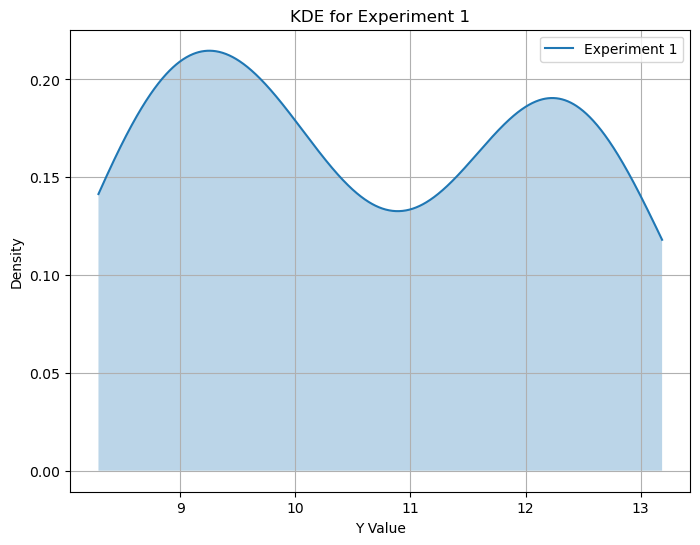

 10%|██████▍                                                         | 1/10 [00:04<00:40,  4.53s/it]

Number of accepted samples: 87


<Figure size 800x600 with 0 Axes>

Text(0.5, 1.0, 'KDE for Experiment 2')

Text(0.5, 0, 'Y Value')

Text(0, 0.5, 'Density')

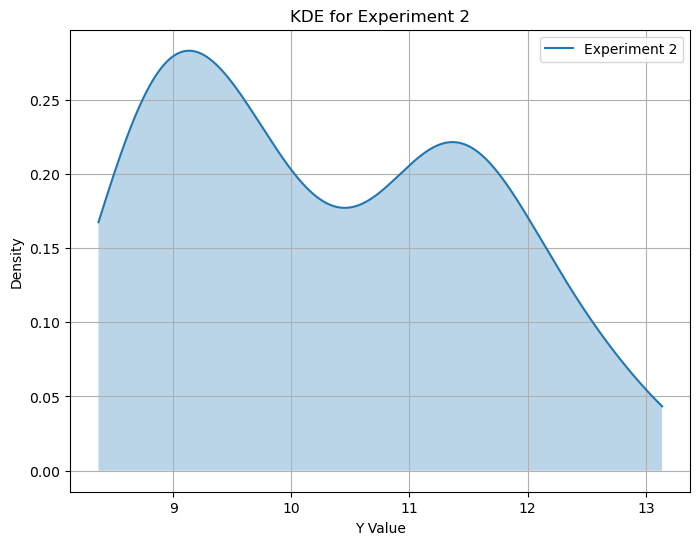

 20%|████████████▊                                                   | 2/10 [00:08<00:34,  4.28s/it]

Number of accepted samples: 76


<Figure size 800x600 with 0 Axes>

Text(0.5, 1.0, 'KDE for Experiment 3')

Text(0.5, 0, 'Y Value')

Text(0, 0.5, 'Density')

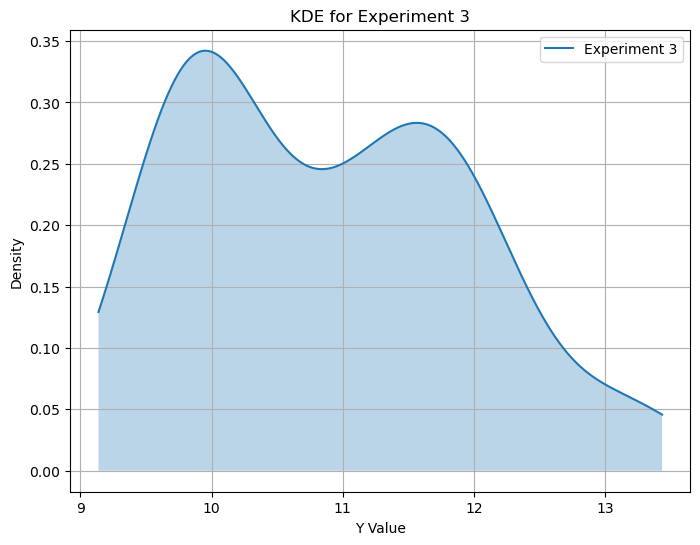

 30%|███████████████████▏                                            | 3/10 [00:12<00:29,  4.26s/it]

Number of accepted samples: 98


<Figure size 800x600 with 0 Axes>

Text(0.5, 1.0, 'KDE for Experiment 4')

Text(0.5, 0, 'Y Value')

Text(0, 0.5, 'Density')

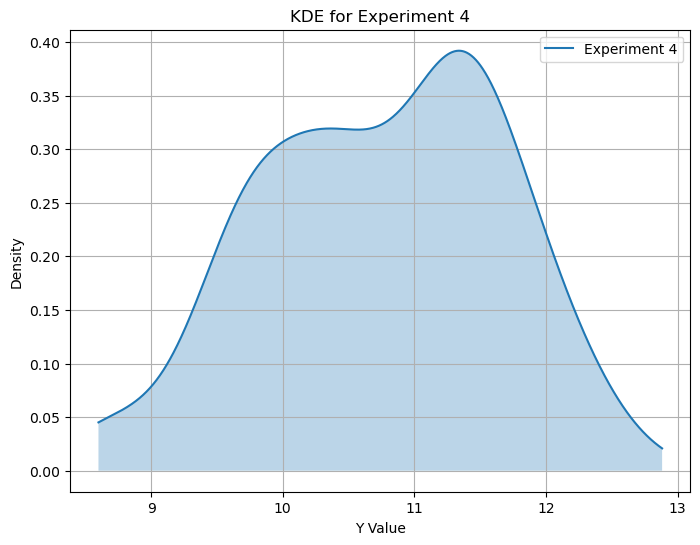

 40%|█████████████████████████▌                                      | 4/10 [00:17<00:26,  4.34s/it]

Number of accepted samples: 99


<Figure size 800x600 with 0 Axes>

Text(0.5, 1.0, 'KDE for Experiment 5')

Text(0.5, 0, 'Y Value')

Text(0, 0.5, 'Density')

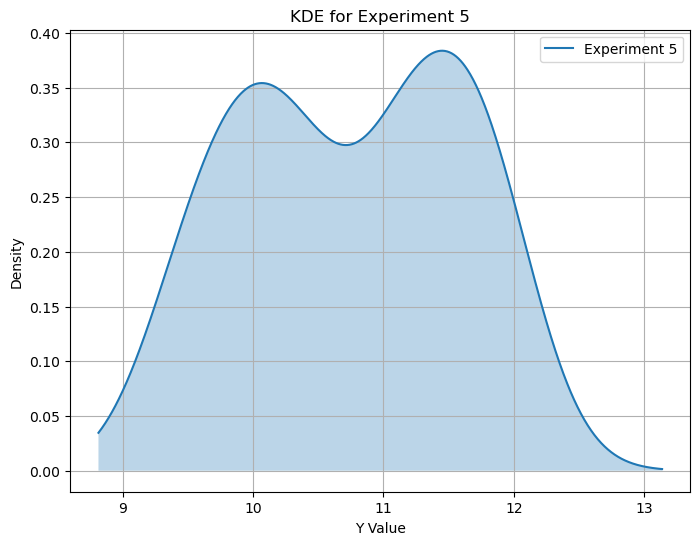

 50%|████████████████████████████████                                | 5/10 [00:21<00:21,  4.34s/it]

Number of accepted samples: 100


<Figure size 800x600 with 0 Axes>

Text(0.5, 1.0, 'KDE for Experiment 6')

Text(0.5, 0, 'Y Value')

Text(0, 0.5, 'Density')

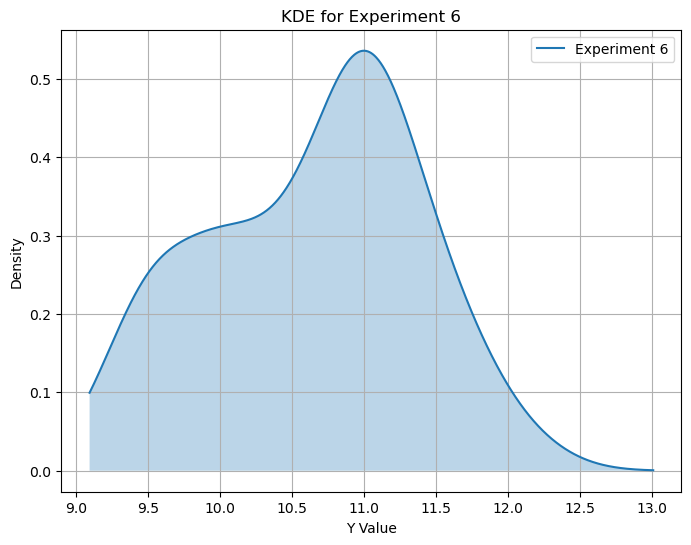

 60%|██████████████████████████████████████▍                         | 6/10 [00:26<00:17,  4.35s/it]

Number of accepted samples: 100


<Figure size 800x600 with 0 Axes>

Text(0.5, 1.0, 'KDE for Experiment 7')

Text(0.5, 0, 'Y Value')

Text(0, 0.5, 'Density')

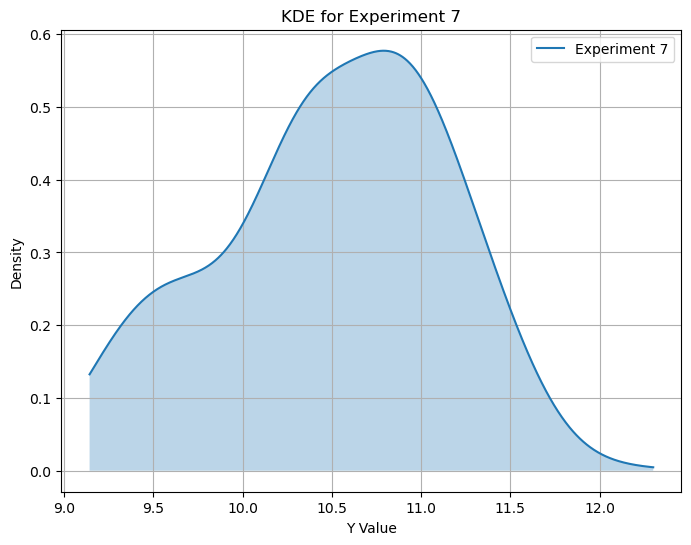

 70%|████████████████████████████████████████████▊                   | 7/10 [00:30<00:12,  4.27s/it]

Number of accepted samples: 100


<Figure size 800x600 with 0 Axes>

Text(0.5, 1.0, 'KDE for Experiment 8')

Text(0.5, 0, 'Y Value')

Text(0, 0.5, 'Density')

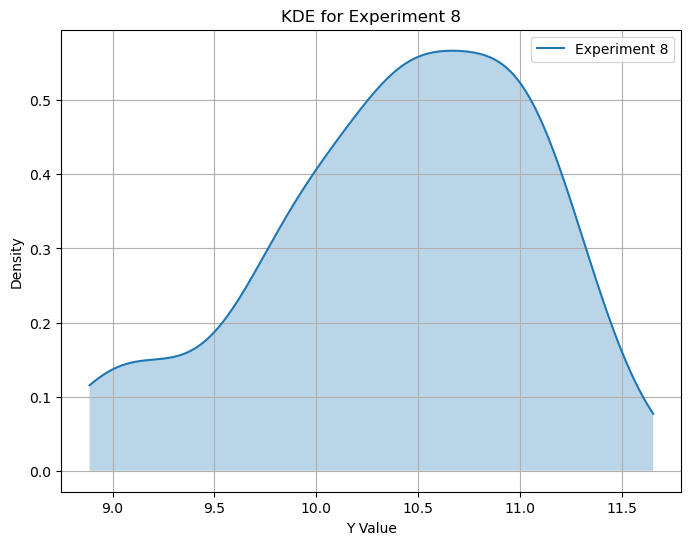

 80%|███████████████████████████████████████████████████▏            | 8/10 [00:34<00:08,  4.31s/it]

Number of accepted samples: 85


<Figure size 800x600 with 0 Axes>

Text(0.5, 1.0, 'KDE for Experiment 9')

Text(0.5, 0, 'Y Value')

Text(0, 0.5, 'Density')

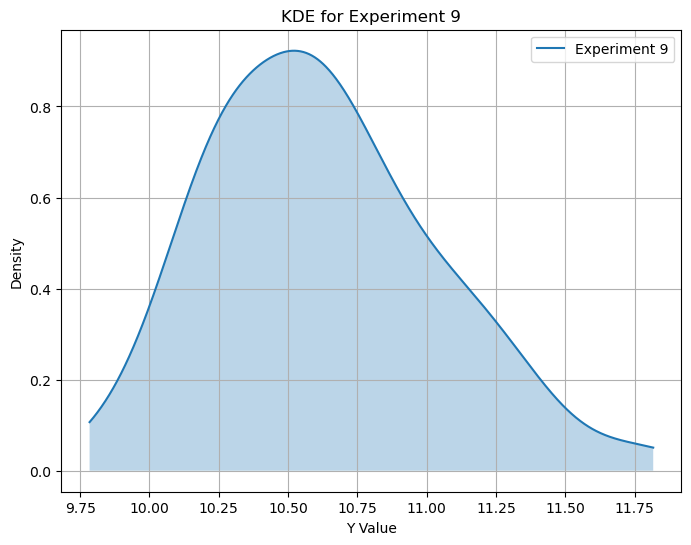

 90%|█████████████████████████████████████████████████████████▌      | 9/10 [00:38<00:04,  4.30s/it]

Number of accepted samples: 100


<Figure size 800x600 with 0 Axes>

Text(0.5, 1.0, 'KDE for Experiment 10')

Text(0.5, 0, 'Y Value')

Text(0, 0.5, 'Density')

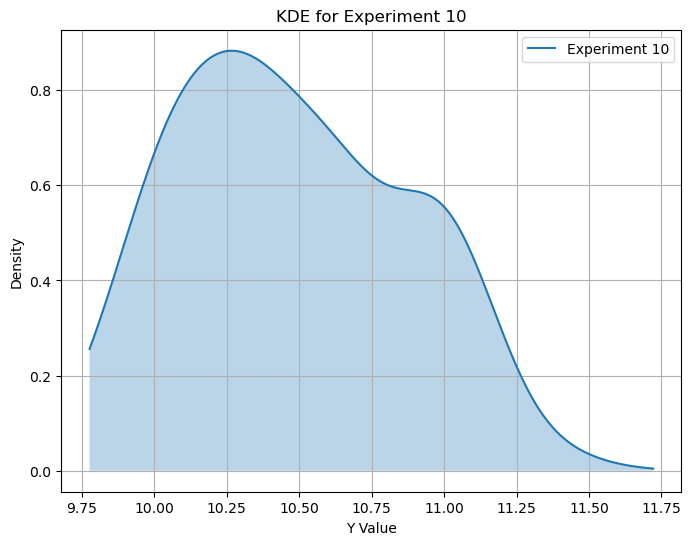

100%|███████████████████████████████████████████████████████████████| 10/10 [00:43<00:00,  4.33s/it]


In [113]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
from tqdm import tqdm

# Number of experiments & trials to run
N_experiments = 10
N_trials = 100

# Storage for results from all experiments
all_experiment_samples = []
all_experiment_weights = []

# Epsilon rejection
epsilon = 0.4

# Run multiple experiments
for exp in tqdm(range(N_experiments), ncols=100):
    # Draw a true Y value for this experiment
    true_Y = true_Y_dist.rvs()

    # Generate the noise
    noise = np.random.normal(loc=noise_mean, scale=noise_sd, size=U_obs.vector().get_local().shape)
    
    # Generate synthetic observation with this true_Y
    solve_linear_model(mesh=mesh, boundaries_mf=boundaries_mf, bcs=bcs, U=U, 
                      Y=true_Y, nu=nu, P=P_obs)
    U_obs = df.Function(U.function_space())
    U_obs.assign(U)
    U_obs.vector()[:] += noise

    
    # Choose the prior
    if exp == 0:
        # Run ABC
        prior_distribution = None
        all_samples, all_weights_norm = ABC_adaptative(U_obs, prior_distribution, N_trials, noise_mean, noise_sd, epsilon,
                                                       first_experiment=True, Y_min=5, Y_max=15)
    
    else:
        prior_distribution = gaussian_kde(all_experiment_samples[-1], weights=all_experiment_weights[-1])
        # Run ABC
        all_samples, all_weights_norm = ABC_adaptative(U_obs, prior_distribution, N_trials, noise_mean, noise_sd, epsilon)
    
    # Store results
    all_experiment_samples.append(np.array(all_samples))
    all_experiment_weights.append(all_weights_norm)
    
    # Plot the KDE for the current experiment
    kde = gaussian_kde(all_samples, weights=all_weights_norm)
    
    # Create a range of values for plotting the KDE
    x_range = np.linspace(min(all_samples), max(all_samples), 1000)
    kde_values = kde(x_range)
    
    # Plot the KDE
    plt.figure(figsize=(8, 6))
    plt.plot(x_range, kde_values, label=f"Experiment {exp+1}")
    plt.fill_between(x_range, kde_values, alpha=0.3)
    plt.title(f"KDE for Experiment {exp+1}")
    plt.xlabel("Y Value")
    plt.ylabel("Density")
    plt.legend()
    plt.grid(True)
    plt.show()


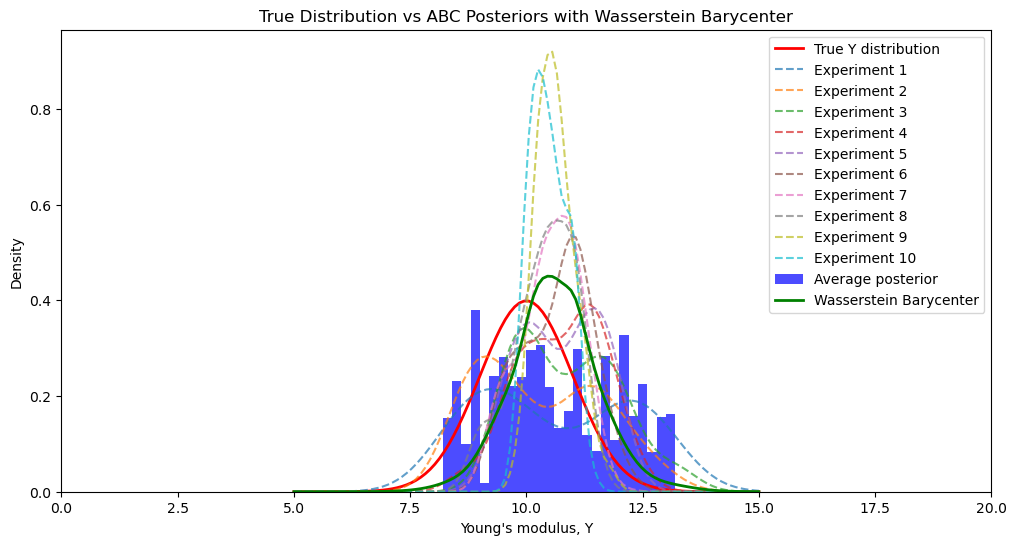

In [114]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import gaussian_kde
import ot  # For Wasserstein distance calculation

def plot_wasserstein_barycenter(all_experiment_samples, all_experiment_weights, true_Y_dist, Y_min, Y_max, plot_each=True):
    """
    Plots the true Y distribution, KDE-smoothed posteriors, and Wasserstein barycenter.
    
    Parameters:
        - all_experiment_samples: List of arrays, each containing samples from an experiment.
        - all_experiment_weights: List of arrays, each containing weights for the corresponding samples.
        - true_Y_dist: The true distribution of Y (must have a .pdf method).
        - Y_min, Y_max: Range for the Y values.
        - plot_each: If True, plots each experiment's posterior separately.
    """
    num_points = 100  # Number of points for interpolation
    y_range = np.linspace(Y_min, Y_max, num_points)
    
    # Step 1: Smooth each experiment's posterior distribution using KDE
    kde_distributions = []
    
    for samples, weights in zip(all_experiment_samples, all_experiment_weights):
        kde = gaussian_kde(samples, weights=weights)
        kde_values = kde(y_range)
        kde_distributions.append(kde_values)
    
    kde_distributions = np.array(kde_distributions)  # Shape: (num_experiments, num_points)
    kde_distributions = kde_distributions.T  # Now shape is (num_points, num_experiments)
    
    num_experiments = kde_distributions.shape[1]
    distances = np.zeros((num_experiments, num_experiments))
    
    # Compute pairwise Wasserstein distances
    for i in range(num_experiments):
        for j in range(i + 1, num_experiments):
            M = np.abs(np.expand_dims(y_range, axis=1) - np.expand_dims(y_range, axis=0))
            mass_a = kde_distributions[:, i] / np.sum(kde_distributions[:, i])
            mass_b = kde_distributions[:, j] / np.sum(kde_distributions[:, j])
            dist = ot.emd2(mass_a, mass_b, M)
            distances[i, j] = dist
            distances[j, i] = dist
    
    # Compute barycenter weights and Wasserstein barycenter
    weights_for_barycenter = 1 / (np.sum(distances, axis=1) + 1e-10)
    weights_for_barycenter /= np.sum(weights_for_barycenter)
    wasserstein_barycenter = np.dot(kde_distributions, weights_for_barycenter)
    
    # Plot results
    plt.figure(figsize=(12, 6))
    bins = 50
    
    # Plot true Y distribution
    plt.plot(y_range, true_Y_dist.pdf(y_range), 'r-', label='True Y distribution', linewidth=2)
    
    # Plot each experiment's KDE-smoothed posterior
    if plot_each:
        for i, (samples, weights) in enumerate(zip(all_experiment_samples, all_experiment_weights)):
            kde = gaussian_kde(samples, weights=weights)
            kde_values = kde(y_range)
            plt.plot(y_range, kde_values, alpha=0.7, label=f'Experiment {i+1}', linestyle='--')
    else:
        for samples, weights in zip(all_experiment_samples, all_experiment_weights):
            kde = gaussian_kde(samples, weights=weights)
            kde_values = kde(y_range)
            plt.plot(y_range, kde_values, alpha=0.1, color='blue')
    
    # Compute and normalize the weighted average posterior
    combined_samples = np.concatenate(all_experiment_samples)
    combined_weights = np.concatenate(all_experiment_weights)
    combined_weights /= np.sum(combined_weights)
    
    # Plot weighted average posterior
    plt.hist(combined_samples, bins=bins, density=True, weights=combined_weights,
             alpha=0.7, color='blue', range=(Y_min, Y_max), label='Average posterior')
    
    # Plot Wasserstein barycenter
    plt.plot(y_range, wasserstein_barycenter, 'g-', linewidth=2, label='Wasserstein Barycenter')
    
    # Finalize plot
    plt.xlabel("Young's modulus, Y")
    plt.ylabel("Density")
    plt.title("True Distribution vs ABC Posteriors with Wasserstein Barycenter")
    plt.legend()
    plt.xlim(Y_min - 5, Y_max + 5)
    plt.show()

# Example Usage
plot_wasserstein_barycenter(all_experiment_samples, all_experiment_weights, true_Y_dist, Y_min, Y_max, plot_each=True)


## Metropolis hastings

In [40]:
from scipy import stats

# 2D Target Distribution (Example: Mixture of Gaussians)
def target_distribution(args):
    """
    Example 2D target distribution: Mixture of two Gaussians.
    Modify this for different distributions.
    """
    x, y = args[0], args[1]  # Ensure args is a tuple (x, y)
    
    return 0.6 * stats.multivariate_normal.pdf([x, y], mean=[2, 3], cov=[[1, 0.5], [0.5, 1]]) + \
           0.4 * stats.multivariate_normal.pdf([x, y], mean=[-2, -3], cov=[[1, -0.3], [-0.3, 1]])


# Proposal Distribution: Gaussian step in both x and y directions
def proposal_distribution(current_state, step_size=0.5):
    """
    Generates a new proposed state by adding Gaussian noise.
    """
    return current_state + np.random.normal(loc=0, scale=step_size, size=2)

# 2D Metropolis-Hastings Algorithm
def metropolis_hastings_2d(true_values, target_distribution, noise_sd, initial_state, num_samples, step_size=0.5, T0=1, beta=0.2):
    """
    Performs Metropolis-Hastings sampling in 2D.
    For ONE experiment.

    Parameters:
        true_values = (Y_true, nu_true)
        target_distribution (function): The target 2D probability density function.
        noise_sd (float): Standard deviation for noise in observations.
        initial_state (array-like): Initial [Y, nu] state.
        num_samples (int): Number of samples.
        step_size (float): Standard deviation for the proposal distribution.
        T0 (float): Initial temperature for simulated annealing.
        beta (float): Cooling rate.

    Returns:
        numpy.ndarray: Sampled (Y, nu) pairs.
    """
    # We create an observed displacement field
    ##########################################
    
    Y_ref, nu_ref = target_distribution(true_values)
    
    solve_nonlinear_model(mesh=mesh, boundaries_mf=boundaries_mf, bcs=bcs, U=U, 
                          Y=Y_ref, nu=nu_ref, P=P_obs)
    
    U_obs = df.Function(U.function_space())
    noise = np.random.normal(loc=0, scale=noise_sd, size=U_obs.vector().get_local().shape)
    U_obs.assign(U)
    U_obs.vector()[:] += noise
    
    # Initialize the sampling process
    samples_list = [np.array(initial_state)]
    
    # Costs list
    costs_list = []
    
    solve_nonlinear_model(mesh=mesh, boundaries_mf=boundaries_mf, bcs=bcs, U=U, 
                          Y=Y_ref, nu=nu_ref, P=P_obs)
    
    cost_value = compute_distance(U, U_obs, eps=1e-12)
    costs_list.append(cost_value)
    
    for i in range(num_samples):
        current_state = samples_list[-1]
        Y, nu = current_state
        
        # Sample new proposed state
        proposed_state = proposal_distribution(current_state, step_size)
        Y_p, nu_p = proposed_state
        
        # Compute the cost of the proposed state
        solve_nonlinear_model(mesh=mesh, boundaries_mf=boundaries_mf, bcs=bcs, U=U, 
                              Y=Y_p, nu=nu_p, P=P_obs)
        
        cost_value_proposed = compute_distance(U, U_obs, eps=1e-12)
        
        # Compute the Tn parameter (cooling schedule)
        Tn = T0 * np.exp(-beta * i)
        
        # Compute α (acceptance ratio)
        if Tn > 0:  # Prevent division by zero
            acceptance_ratio = min(1, np.exp((costs_list[-1] - cost_value_proposed) / Tn))
        else:
            acceptance_ratio = 1 if cost_value_proposed < costs_list[-1] else 0

        # Accept or reject
        if np.random.rand() < acceptance_ratio:
            samples_list.append(proposed_state)
            costs_list.append(cost_value_proposed)
        else:
            samples_list.append(current_state)
            costs_list.append(costs_list[-1])

    return np.array(samples_list)

In [41]:
# Generate Samples
initial_state = [0, 0]  # Start at (0,0)
num_samples = 5000  # Number of samples
samples = metropolis_hastings_2d(true_values = [10.0, 0.3], target_distribution = target_distribution, noise_sd = 0.05, 
                                 initial_state = [11.0,0.4], num_samples = num_samples)

# Plot Contour of Target Distribution
x = np.linspace(-5, 5, 100)
y = np.linspace(-5, 5, 100)
X, Y = np.meshgrid(x, y)
Z = np.array([[target_distribution(x, y) for x, y in zip(row_x, row_y)] for row_x, row_y in zip(X, Y)])

plt.figure(figsize=(8, 6))
plt.contourf(X, Y, Z, levels=20, cmap="coolwarm", alpha=0.6)  # Contour plot of target distribution
plt.colorbar(label="Probability Density")

# Scatter Plot of Sampled Points
plt.scatter(samples[:, 0], samples[:, 1], s=2, alpha=0.4, color="black", label="Sampled Points")

# Labels and Title
plt.title("Metropolis-Hastings 2D Sampling with Target Contour")
plt.xlabel("X")
plt.ylabel("Y")
plt.legend()
plt.show()

TypeError: cannot unpack non-iterable numpy.float64 object